# Notebook to make figures for presentations, manuscripts, etc.

Rainey Aberle

2022/2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import rioxarray as rxr
import contextily as cx
import geopandas as gpd
import pandas as pd
from skimage.measure import find_contours
import ee
import sys
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import rasterio as rio
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, LightSource
import glob
import wxee as wx
import matplotlib
import pickle
from scipy.signal import medfilt
from scipy.stats import iqr
import os
import glob
import operator
import json
from ast import literal_eval
import seaborn as sns
import wxee as wx
import geedim as gd
import requests
from PIL import Image
import io
from shapely import wkt
from tqdm.auto import tqdm

# path to snow-cover-mapping/
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'

# path to study-sites/
study_sites_path = '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/'

# determine whether to save output figures
save_figures = True

# path for saving output figures
figures_out_path = os.path.join(base_path, 'figures')

# add path to functions
sys.path.insert(1, os.path.join(base_path, 'functions'))
import pipeline_utils as f
import PlanetScope_preprocessing as psp

# load dataset dictionary
dataset_dict = json.load(open(os.path.join(base_path,'inputs-outputs', 'datasets_characteristics.json')))

### Define some colormaps

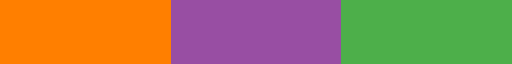

In [2]:
# -----Imagery Datasets
color_Landsat = '#ff7f00'
color_Sentinel2 = '#984ea3'
color_PlanetScope = '#4daf4a'

ListedColormap([color_Landsat, color_Sentinel2, color_PlanetScope])

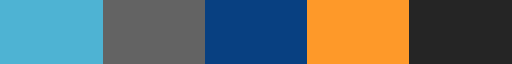

In [3]:
# -----Classified images
# Indicies: 0 = snow, 1 = shadowed snow, 2 = ice, 3 = bare ground, 4 = water
colors_classified = list(dataset_dict['classified_image']['class_colors'].values())
ListedColormap(colors_classified)

## Figure 1. Spectral signatures for earth materials and satellite band ranges and example NDSI thresholding applied to an image at Wolverine

Downloading:   0%|          | 0.00/1.24M [00:00<?, ?iB/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


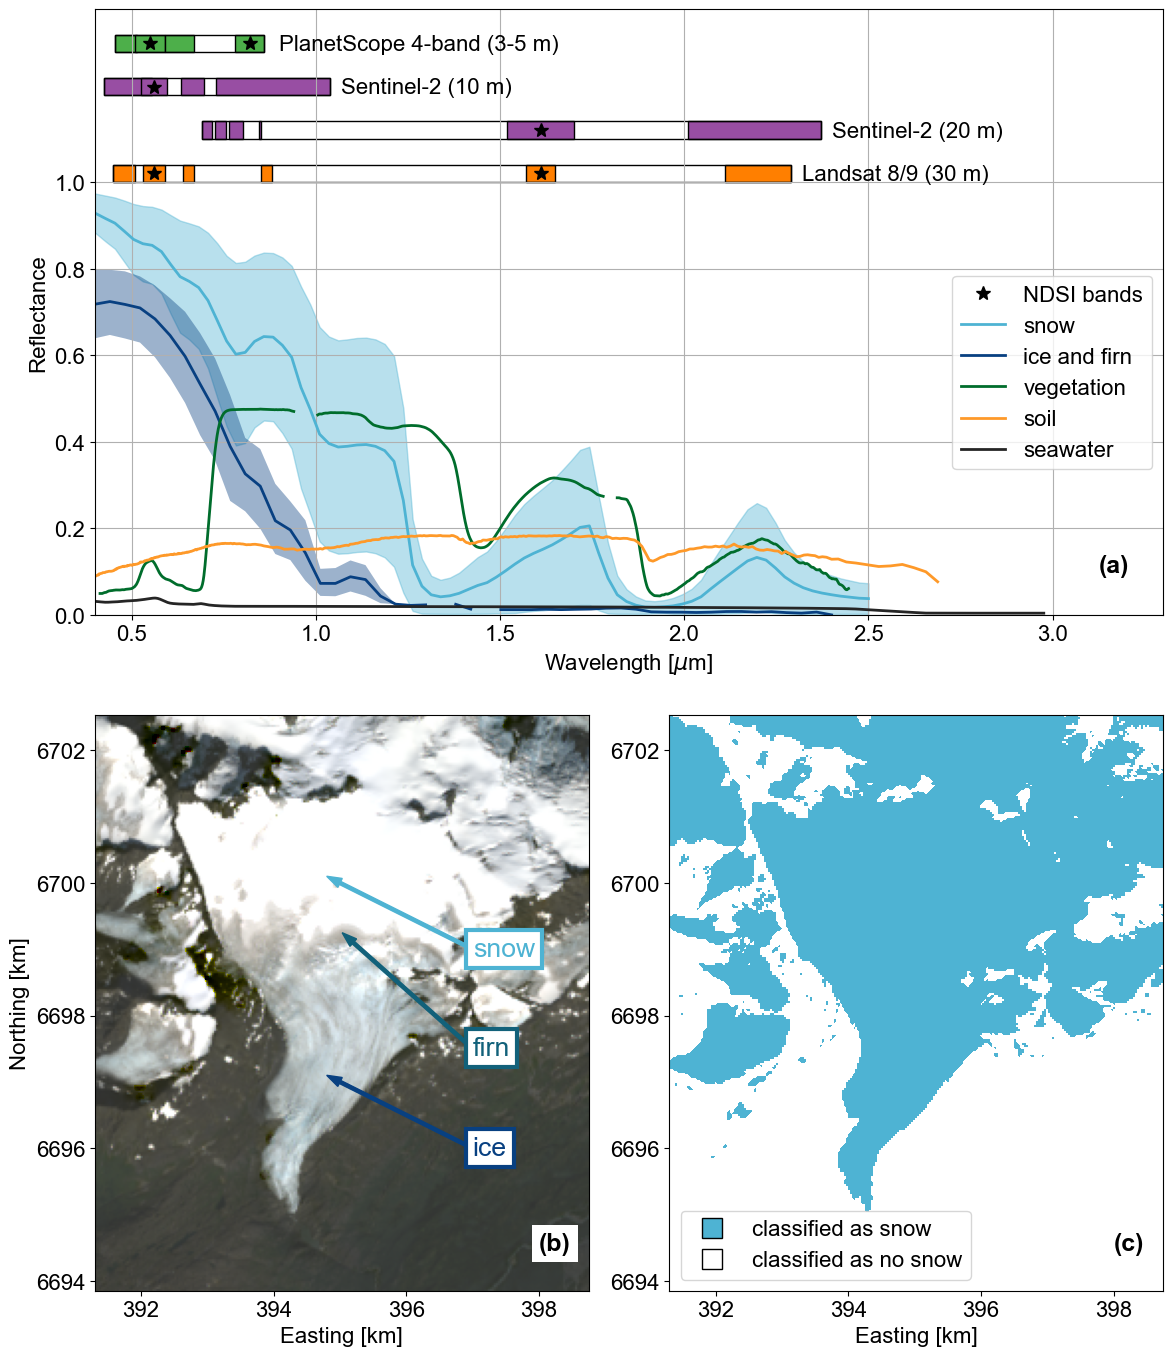

figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/fig01_spectral_signatures_satellite_bands.png


In [5]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

# -----Set up figure
# define colors for different materials
color_snow = colors_classified[0]
color_firn = '#12617a'
color_ice = colors_classified[2]
color_dirty_ice = '#1a2c40'
color_veg = '#006d2c'
color_rock = colors_classified[3]
color_water = colors_classified[4]
# plot
fontsize = 16
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig = plt.figure(figsize=(12,14))
linewidth=2
# define axes layout using gridspec
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])
ax = [fig.add_subplot(gs[0, :]), fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]

# -----Plot satellite band ranges
def draw_boxes(axis, band_ranges, NDSI_indices, y0=0.2, box_height=0.04, 
               facecolor='#bdbdbd', edgecolor='k', alpha=1.0, NDSI_label=False):
    labeled = False
    # loop over band ranges
    for i, band_range in enumerate(band_ranges):
        # convert from nanometers to micrometers
        x0, x1 = band_range[0], band_range[1]
        # calculate width
        box_width = x1-x0
        # create rectangle and add to axes
        axis.add_patch(Rectangle((x0, y0), width=box_width, height=box_height, 
                       facecolor=facecolor, edgecolor=edgecolor, alpha=alpha))
        # plot star on NDSI bands
        if i in NDSI_indices:
            if (not labeled) and NDSI_label:
                label = 'NDSI bands'
                labeled = True
            else:
                label='_nolegend_'
            axis.plot(x0 + box_width/2, y0 + box_height/2, '*k', markersize=10, label=label)

    # add one rectangle to contain all bands
    x0, x1 = band_ranges[0][0], band_ranges[-1][-1]
    box_width = x1-x0
    axis.add_patch(Rectangle((x0, y0), width=box_width, height=box_height, facecolor='none', edgecolor='k', alpha=1.0))
    return

# Landsat 8/9 OLI
L_band_ranges = [[0.45, 0.51], [0.53, 0.59], [0.64, 0.67], [0.85, 0.88], # 2, 3, 4, 5
                 [1.57, 1.65], [2.11, 2.29]] # 6, 7
L_band_names = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2']#, 'TIRS1', 'TIRS2']
L_NDSI_band_indices = [1, 4]
draw_boxes(ax[0], L_band_ranges, L_NDSI_band_indices, y0=1.001, NDSI_label=True, facecolor=color_Landsat)
ax[0].text(2.32, 1.005, 'Landsat 8/9 (30 m)')
# Sentinel-2 MSI
S2_20_band_ranges = [[0.69, 0.718], [0.727, 0.755], [0.764, 0.802], # B5, B6, B7
                     [0.845, 0.85], [1.52, 1.70], [2.010, 2.37]] # B8A, B11 (SWIR1), B12 (SWIR2)
S2_20_NDSI_band_indices = [4]
draw_boxes(ax[0], S2_20_band_ranges, S2_20_NDSI_band_indices, y0=1.101, facecolor=color_Sentinel2)
ax[0].text(2.4, 1.105, 'Sentinel-2 (20 m)')

S2_10_band_ranges = [[0.425, 0.555], [0.525, 0.595], [0.635, 0.695], # B2 B3 B4 
                     [0.728, 1.038]] # B8 (NIR)
S2_10_NDSI_band_indices = [1]
draw_boxes(ax[0], S2_10_band_ranges, S2_10_NDSI_band_indices, y0=1.201, facecolor=color_Sentinel2)
ax[0].text(1.068, 1.205, 'Sentinel-2 (10 m)')
# PlanetScope 4-band
PS_band_ranges = [[0.455, 0.515], [0.51, 0.59], [0.590, 0.670], [0.780, 0.860]]
PS_NDSI_indices = [1, 3]
draw_boxes(ax[0], PS_band_ranges, PS_NDSI_indices, y0=1.301, facecolor=color_PlanetScope)
ax[0].text(0.90, 1.305, 'PlanetScope 4-band (3-5 m)')

# -----Load spectral signatures data and plot
# Painter et al. (2009): snow, coarse- to fine-grained
spec_path_painter = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/figures/spectral_signatures_Painter_et_al_2009'
os.chdir(spec_path_painter)
coarse_snow = pd.read_csv('coarse_snow_Painter_et_al_2009.csv', header=None)
fine_snow = pd.read_csv('fine_snow_Painter_et_al_2009.csv', header=None)
# interpolate to same x values
x_snow = np.linspace(0, 2.5, num=100)
y_coarse = np.interp(x_snow, coarse_snow[0].values, coarse_snow[1].values)
y_fine = np.interp(x_snow, fine_snow[0].values, fine_snow[1].values)
y_med = np.array([np.nanmean([y1, y2]) for y1, y2 in list(zip(y_coarse, y_fine))])
# plot
ax[0].fill_between(x_snow, y_fine, y_coarse, color=color_snow, alpha=0.4)
ax[0].plot(x_snow, y_med, '-', color=color_snow, linewidth=linewidth, label='snow')
# Salvatori et al. (2022): ice 
spec_path_salv = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/figures/spectral_signatures_Salvatori_et_al_2022'
os.chdir(spec_path_salv)
ice = pd.read_csv('ice.csv', header=None)
# interpolate min, max, and mean values
x_ice = np.linspace(0.4, 2.4, num=50)
dx = x_ice[1] - x_ice[0]
y_ice_min, y_ice_max, y_ice_mean = np.zeros(len(x_ice)), np.zeros(len(x_ice)), np.zeros(len(x_ice))
for i in range(0,len(x_ice)-1):
    x_window = [x_ice[i] - dx/2, x_ice[i] + dx/2]
    if np.any((ice[0].values > x_window[0]) & (ice[0].values < x_window[1])):
        y_ice_min[i] = np.nanmin(ice[1].values[(ice[0].values > x_window[0]) & (ice[0].values < x_window[1])])
        y_ice_max[i] = np.nanmax(ice[1].values[(ice[0].values > x_window[0]) & (ice[0].values < x_window[1])])
        y_ice_mean[i] = np.nanmean(ice[1].values[(ice[0].values > x_window[0]) & (ice[0].values < x_window[1])])
    else:
        y_ice_min[i], y_ice_max[i], y_ice_mean[i] = np.nan, np.nan, np.nan
# plot
ax[0].fill_between(x_ice, y_ice_min, y_ice_max, facecolor=color_ice, edgecolor=None, alpha=0.4)
ax[0].plot(x_ice, y_ice_mean, '-', color=color_ice, linewidth=linewidth, label='ice and firn')
# Zeng et al. (1984) / Hendriks et al. (2003): firn
# spec_path_zeng = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/figures/spectral_signatures_firn_Hendriks_et_al_2003'
# firn = pd.read_csv(os.path.join(spec_path_zeng, 'Firn.csv'), header=None)
# firn.rename(columns={0:'Wavelength', 1:'Reflectance'}, inplace=True)
# firn.sort_values(by='Wavelength', inplace=True)
# firn['Wavelength'] = firn['Wavelength'] / 1000
# firn.loc[firn['Reflectance'] <= 0] = np.nan
# firn.dropna(inplace=True)
# firn.reset_index(drop=True, inplace=True)
# dirty_ice = pd.read_csv(os.path.join(spec_path_zeng, 'Dirty glacier ice.csv'), header=None)
# dirty_ice.rename(columns={0:'Wavelength', 1:'Reflectance'}, inplace=True)
# dirty_ice.sort_values(by='Wavelength', inplace=True)
# dirty_ice['Wavelength'] = dirty_ice['Wavelength'] / 1000
# dirty_ice.reset_index(drop=True, inplace=True)
# # plot
# ax[0].plot(firn['Wavelength'], firn['Reflectance'], '-', color=color_firn, label='firn')
# ax[0].plot(dirty_ice['Wavelength'], dirty_ice['Reflectance'], '-', color=color_dirty_ice, label='dirty glacier ice')

# USGS: vegetation, soil, seawater
colors = [color_veg, color_rock, color_water]
spec_path_usgs = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/figures/spectral_signatures_USGS/'
os.chdir(spec_path_usgs)
# define prefixes used in file names for each material
prefixes = ['Aspen', 'Basalt', 'Seawater']
# define labels for plot
labels = ['vegetation', 'soil', 'seawater']
# loop through prefixes
for i, prefix in enumerate(prefixes):
    # grab folder name
    folder = glob.glob('*'+prefix+'*')[0]
    # load wavelengths
    wave_fn = glob.glob(folder + '/*Wavelengths*.txt')[0]
    wave = pd.read_csv(wave_fn)
    wave = wave[wave.keys()[0]].values
    if prefix=='Basalt':
        refl_fn = glob.glob(folder + '/*'+prefix+'*.txt')[1]
    else:
        refl_fn = glob.glob(folder + '/*'+prefix+'*.txt')[0]
    refl = pd.read_csv(refl_fn)
    refl = refl[refl.keys()[0]].values
    refl[refl<0] = np.nan
    # plot
    ax[0].plot(wave, refl, '-', color=colors[i], linewidth=linewidth, label=labels[i])
    
ax[0].grid(True)
ax[0].set_xlim(0.4, 3.3)
ax[0].set_ylim(0, 1.4)
ax[0].set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax[0].legend(loc='center right', bbox_to_anchor=[0.8, 0.3, 0.2, 0.2])
ax[0].set_xlabel('Wavelength [$\mu$m]')
ax[0].set_ylabel('Reflectance')
ax[0].text((ax[0].get_xlim()[1] - ax[0].get_xlim()[0])*0.94 + ax[0].get_xlim()[0],
           (ax[0].get_ylim()[1] - ax[0].get_ylim()[0])*0.07 + ax[0].get_ylim()[0], '(a)', fontweight='bold', fontsize=fontsize+2, 
           bbox=dict(facecolor='white', edgecolor='None', pad=5))

# -----Load Landsat image at Wolverine
# image datetime
dt = np.datetime64('2020-08-17')
# load AOI
AOI_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/Aberle_et_al_dataset_submission/Wolverine/AOIs'
AOI_fn = glob.glob(os.path.join(AOI_path, 'Wolverine_Glacier_Boundaries_20201019.shp'))[0]
AOI_UTM = gpd.read_file(AOI_fn)
# initialize GEE
ee.Initialize()

def query_gee_for_image(dt, aoi_utm):
    # -----Grab datetime from snowline df
    date_start = str(dt - np.timedelta64(1, 'D'))
    date_end = str(dt + np.timedelta64(1, 'D'))
    # -----Buffer AOI by 1km
    aoi_utm_buffer = aoi_utm.buffer(1e3)
    # determine bounds for image plotting
    bounds = aoi_utm_buffer.geometry[0].bounds
    # -----Reformat AOI for image filtering
    # reproject CRS from AOI to WGS
    aoi_wgs = aoi_utm.to_crs('EPSG:4326')
    aoi_buffer_wgs = aoi_utm_buffer.to_crs('EPSG:4326')
    # prepare AOI for querying geedim (AOI bounding box)
    region = {'type': 'Polygon',
              'coordinates': [[[aoi_buffer_wgs.geometry.bounds.minx[0], aoi_buffer_wgs.geometry.bounds.miny[0]],
                               [aoi_buffer_wgs.geometry.bounds.maxx[0], aoi_buffer_wgs.geometry.bounds.miny[0]],
                               [aoi_buffer_wgs.geometry.bounds.maxx[0], aoi_buffer_wgs.geometry.bounds.maxy[0]],
                               [aoi_buffer_wgs.geometry.bounds.minx[0], aoi_buffer_wgs.geometry.bounds.maxy[0]],
                               [aoi_buffer_wgs.geometry.bounds.minx[0], aoi_buffer_wgs.geometry.bounds.miny[0]]
                               ]]}
    region_buffer_ee = ee.Geometry.Polygon([[[aoi_buffer_wgs.geometry.bounds.minx[0], aoi_buffer_wgs.geometry.bounds.miny[0]],
                                              [aoi_buffer_wgs.geometry.bounds.maxx[0], aoi_buffer_wgs.geometry.bounds.miny[0]],
                                              [aoi_buffer_wgs.geometry.bounds.maxx[0], aoi_buffer_wgs.geometry.bounds.maxy[0]],
                                              [aoi_buffer_wgs.geometry.bounds.minx[0], aoi_buffer_wgs.geometry.bounds.maxy[0]],
                                              [aoi_buffer_wgs.geometry.bounds.minx[0], aoi_buffer_wgs.geometry.bounds.miny[0]]
                                            ]])

    # -----Query GEE for Landsat 8 imagery
    im_col_gd = gd.MaskedCollection.from_name('LANDSAT/LC08/C02/T1_L2').search(start_date=date_start,
                                                                               end_date=date_end,
                                                                               mask=True,
                                                                               region=region,
                                                                               fill_portion=50)
    im_col_ee = im_col_gd.ee_collection
    
    # -----Return first image as xarray.Dataset
     # Grab first image
    im_ee = im_col_ee.first()
    # create MaskedImage from ID
    im_gd = gd.MaskedImage.from_id(im_ee.getInfo()['id'], mask=False, region=region)
    # convert to ee.Image
    im_ee = ee.Image(im_gd.ee_image).select(im_gd.refl_bands)
    # convert to xarray.Datasets
    crs = str(AOI_UTM.crs.to_epsg())
    im_xr = im_ee.wx.to_xarray(scale=30, region=region, crs='EPSG: '+ crs)
    # account for image scalar
    im_xr = xr.where(im_xr != dataset_dict['Landsat']['no_data_value'],
                     im_xr / dataset_dict['Landsat']['image_scalar'], np.nan)
    # set CRS
    im_xr.rio.write_crs('EPSG:' + crs, inplace=True)
    
    return im_xr

im_xr = query_gee_for_image(dt, AOI_UTM)

# -----Calcualte NDSI
NDSI = ((im_xr[dataset_dict['Landsat']['NDSI_bands'][0]].data[0] - im_xr[dataset_dict['Landsat']['NDSI_bands'][1]].data[0])
        / (im_xr[dataset_dict['Landsat']['NDSI_bands'][0]].data[0] + im_xr[dataset_dict['Landsat']['NDSI_bands'][1]].data[0]))
NDSI_thresh = np.where(NDSI > 0.4, 1, 0)
NDSI_cmap = ListedColormap(['white', dataset_dict['classified_image']['class_colors']['Snow']])

# ----- Plot
xticks = np.arange(int(np.min(im_xr.x.data)/1e3)+1, np.max(im_xr.x.data)/1e3, step=2)
yticks = np.arange(int(np.min(im_xr.y.data)/1e3)+1, np.max(im_xr.y.data)/1e3, step=2)
ax[1].imshow(np.dstack([im_xr['SR_B4'].data[0], im_xr['SR_B3'].data[0], im_xr['SR_B2'].data[0]]),
             extent=(np.min(im_xr.x.data)/1e3, np.max(im_xr.x.data)/1e3, np.min(im_xr.y.data)/1e3, np.max(im_xr.y.data)/1e3))
ax[1].set_xticks(xticks)
ax[1].set_yticks(yticks)
ax[1].grid(False)
ax[1].set_xlabel('Easting [km]')
ax[1].set_ylabel('Northing [km]')
ax[1].text((ax[1].get_xlim()[1] - ax[1].get_xlim()[0])*0.9 + ax[1].get_xlim()[0],
           (ax[1].get_ylim()[1] - ax[1].get_ylim()[0])*0.07 + ax[1].get_ylim()[0], '(b)', fontweight='bold', fontsize=fontsize+2, 
           bbox=dict(facecolor='white', edgecolor='None', pad=5))
ax[2].imshow(NDSI_thresh, cmap=NDSI_cmap,
             extent=(np.min(im_xr.x.data)/1e3, np.max(im_xr.x.data)/1e3, np.min(im_xr.y.data)/1e3, np.max(im_xr.y.data)/1e3))
ax[2].set_xticks(xticks)
ax[2].set_yticks(yticks)
ax[2].grid(False)
ax[2].set_xlabel('Easting [km]')
ax[2].text((ax[2].get_xlim()[1] - ax[2].get_xlim()[0])*0.9 + ax[2].get_xlim()[0],
           (ax[2].get_ylim()[1] - ax[2].get_ylim()[0])*0.07 + ax[2].get_ylim()[0], '(c)', fontweight='bold', fontsize=fontsize+2, 
           bbox=dict(facecolor='white', edgecolor='None', pad=5))
# plot dummy points for legend
xlim, ylim = ax[2].get_xlim(), ax[2].get_ylim()
ax[2].plot(0, 0, 's', markersize=15, markerfacecolor=NDSI_cmap(1), markeredgecolor='k', linewidth=1, label='classified as snow')
ax[2].plot(0, 0, 's', markersize=15, markerfacecolor='w', markeredgecolor='k', linewidth=1, label='classified as no snow')
ax[2].legend(loc='lower left')
# reset axis limits
ax[2].set_xlim(xlim)
ax[2].set_ylim(ylim)

# annotations
# snow
ax[1].arrow(397, 6699, -2, 1, color=colors_classified[0], width=0.05)
ax[1].text(397, 6698.9, 'snow', color=colors_classified[0], fontsize='large',
           bbox=dict(facecolor='white', edgecolor=colors_classified[0], linewidth=3, pad=5))
# firn
ax[1].arrow(397, 6697.5, -1.8, 1.6, color=color_firn, width=0.05)
ax[1].text(397, 6697.4, 'firn', color=color_firn, fontsize='large',
           bbox=dict(facecolor='white', edgecolor=color_firn, linewidth=3, pad=5))
# ice
ax[1].arrow(397, 6696, -2, 1, color=colors_classified[2], width=0.05)
ax[1].text(397, 6695.9, 'ice', color=colors_classified[2], fontsize='large',
           bbox=dict(facecolor='white', edgecolor=colors_classified[2], linewidth=3, pad=5))


fig.tight_layout()
plt.show()

# -----Save figure to file
if save_figures:
    fig_fn = os.path.join(figures_out_path, 'fig01_spectral_signatures_satellite_bands.png')
    fig.savefig(fig_fn, facecolor='w', dpi=300, bbox_inches='tight')
    print('figure saved to file: ' + fig_fn)

## Figure 2. Study sites - USGS Benchmark Glaciers & Emmons Glacier, WA

In [26]:
# -----Load RGI data
# path to RGI data
rgi_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/RGI/'
# RGI shapefile names
rgi_fns = ['01_rgi60_Alaska/01_rgi60_Alaska.shp', 
           '02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp']
# load and combine rgis
rgis = gpd.GeoDataFrame()
for rgi_fn in rgi_fns:
    rgi = gpd.read_file(rgi_path + rgi_fn)
    rgis = pd.concat([rgis, rgi])
rgis.reset_index(drop=True, inplace=True)

In [ ]:
# -----Count number of glaciers with areas < 1 km^2 (for manuscript)
print('Total # of glaciers in RGI regions 1 and 2 = ', len(rgis))
print('Number of glaciers with areas < 1 km^2 = ', len(rgis.loc[rgis['Area'] < 1]))
print('Percentage of glaciers with areas < 1 km^2 = ', len(rgis.loc[rgis['Area'] < 1]) / len(rgis))
print(' ')

# -----Count total area of glaciers with areas < 1 km^2 with respect to total glacier area (for manuscript)
lt1_area = np.sum(rgis.loc[rgis['Area'] < 1, 'Area'].values)
gte1_area = np.sum(rgis.loc[rgis['Area'] >= 1, 'Area'].values)
print('Total area of glaciers with area < 1 km^2 = ', lt1_area, ' km^2')
print('Total area of glaciers with area >= 1 km^2 = ', gte1_area, ' km^2')
print('Areal percentage of glaciers with area < 1 km^2 = ', lt1_area / gte1_area)

/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5211/1966596530.py:112: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_5211/1966596530.py:112: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  fig.tight_layout()


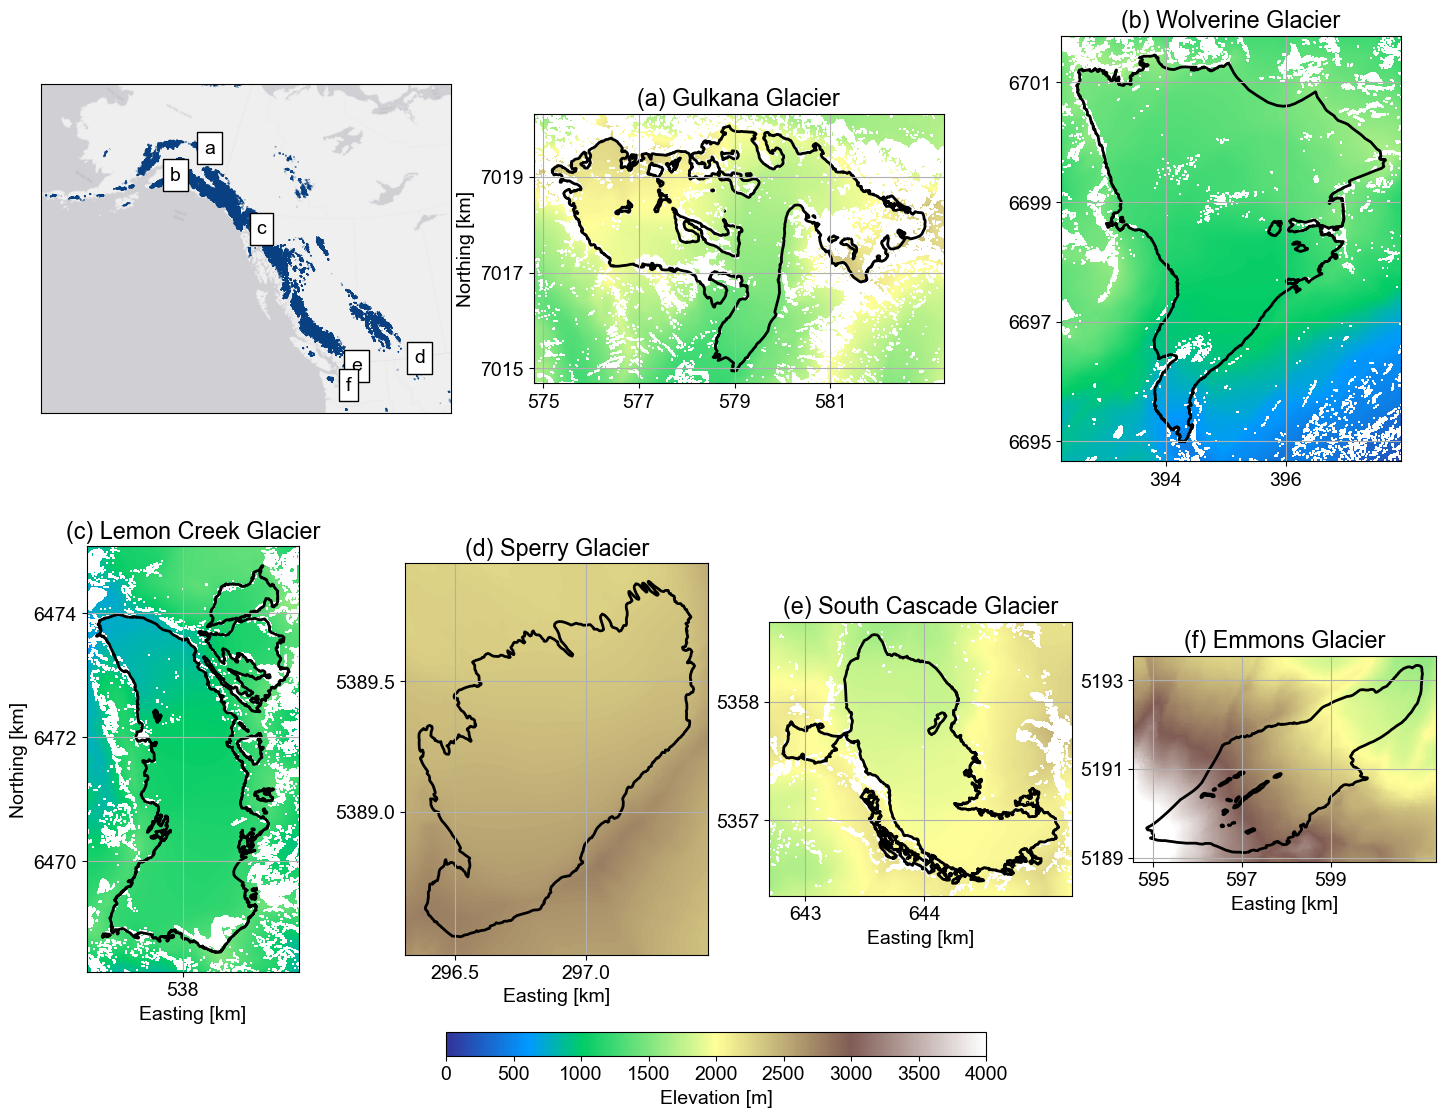

figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/fig02_study_sites_elevations.png


In [55]:
# -----Define site specifics
site_names = ['Gulkana', 'Wolverine', 'LemonCreek', 'Sperry', 'SouthCascade', 'Emmons']
site_names_display = [x.replace('C', ' C') for x in site_names]
text_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# -----Define colormap for elevations
cmap_elev = plt.cm.terrain(np.linspace(0, 1, 100))
cmap_elev = ListedColormap(cmap_elev[25:, :])

# -----Define colormap for glacier outline timeseries
cmap_time = matplotlib.cm.Greys_r
cmap_time_norm = matplotlib.colors.Normalize(vmin=2013, vmax=2022)

# -----Set up figure
fontsize = 14
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig = plt.figure(figsize=(18, 12))
ax = [fig.add_subplot(2, 3, 1), fig.add_subplot(2, 3, 2), fig.add_subplot(2, 3, 3),
      fig.add_subplot(2, 4, 5), fig.add_subplot(2, 4, 6), fig.add_subplot(2, 4, 7), fig.add_subplot(2, 4, 8)]
epsg_A = 32610    
    
# -----Loop through sites
for i, (site_name, site_name_display, text_label) in enumerate(zip(site_names, site_names_display, text_labels)):
    ### AOI
    # load file
    if site_name=='Emmons':
        AOI_fn = glob.glob(os.path.join(study_sites_path, site_name, 'AOIs', site_name + '_RGI_outline.shp'))[0]
    else:
        AOI_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/Aberle_et_al_dataset_submission'
        AOI_fn = sorted(glob.glob(os.path.join(AOI_path, site_name, 'AOIs', site_name + '_Glacier_Boundaries_*.shp')))[-1]
    AOI = gpd.read_file(AOI_fn)
    AOI_WGS = AOI.to_crs(4326)
    # solve for optimal UTM zone
    AOI_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
    epsg_UTM = f.convert_wgs_to_utm(AOI_centroid[0], AOI_centroid[1])
    # reproject
    AOI_UTM = AOI_WGS.to_crs(epsg_UTM)
    AOI_A = AOI.to_crs(epsg_A)
    ### DEM
    if site_name=='Emmons':
        DEM_fn =  glob.glob(os.path.join(study_sites_path, site_name, 'DEMs', site_name + '*NASADEM*.tif'))[0]
    else:
        DEM_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/USGS/DEMs/' + site_name
        DEM_fn =  sorted(glob.glob(os.path.join(DEM_path, site_name + '*_DEM.tif')))[-1]
    DEM = xr.open_dataset(DEM_fn)
    DEM = DEM.rename({'band_data': 'elevation'})
    # reproject 
    DEM = DEM.rio.reproject(str('EPSG:'+epsg_UTM))
    ### Plot
    # A) Study sites map
    ax[0].plot(AOI_A.geometry[0].centroid.xy[0][0], AOI_A.geometry[0].centroid.xy[1][0], '.', markersize=5)
    ax[0].text(AOI_A.geometry[0].centroid.xy[0][0], AOI_A.geometry[0].centroid.xy[1][0],
               text_labels[i].replace('(','').replace(')',''), bbox=dict(facecolor='white', edgecolor='black', pad=5))
    # Individual glacier plot
    DEM_im = ax[i+1].imshow(DEM.elevation.data[0], extent=(np.min(DEM.x.data), np.max(DEM.x.data), np.min(DEM.y.data), np.max(DEM.y.data)),
                            cmap=matplotlib.cm.terrain, clim=(0,4000))
    AOI_UTM.plot(ax=ax[i+1], edgecolor='k', facecolor='none', linewidth=2)
    if AOI_UTM.geometry[0].geom_type=='MultiPolygon':
        xmin_AOI = np.min([np.min(geom.exterior.coords.xy[0]) for geom in AOI_UTM.geometry[0].geoms])
        xmax_AOI = np.max([np.max(geom.exterior.coords.xy[0]) for geom in AOI_UTM.geometry[0].geoms])
        ymin_AOI = np.min([np.min(geom.exterior.coords.xy[1]) for geom in AOI_UTM.geometry[0].geoms])
        ymax_AOI = np.max([np.max(geom.exterior.coords.xy[1]) for geom in AOI_UTM.geometry[0].geoms])      
    else:
        xmin_AOI = np.min(AOI_UTM.geometry[0].exterior.coords.xy[0])
        xmax_AOI = np.max(AOI_UTM.geometry[0].exterior.coords.xy[0])
        ymin_AOI = np.min(AOI_UTM.geometry[0].exterior.coords.xy[1])
        ymax_AOI = np.max(AOI_UTM.geometry[0].exterior.coords.xy[1])  
    xmin = xmin_AOI - 0.05*(xmax_AOI - xmin_AOI)
    xmax = xmax_AOI + 0.05*(xmax_AOI - xmin_AOI)
    ymin = ymin_AOI - 0.05*(ymax_AOI - ymin_AOI)
    ymax = ymax_AOI + 0.05*(ymax_AOI - ymin_AOI) 
    # change x and y tick labels to km
    if (i < 3) or (i==5):
        ax[i+1].set_xticks(np.arange(np.round(xmin,-3), np.round(xmax,-3), 2e3))
        ax[i+1].set_yticks(np.arange(np.round(ymin,-3), np.round(ymax,-3), 2e3)) 
    elif i==3:
        ax[i+1].set_xticks([296500, 297000])
        ax[i+1].set_yticks([5389000, 5389500])
    else:
        ax[i+1].set_xticks(np.arange(np.round(xmin,-3), np.round(xmax,-3), 1e3))
        ax[i+1].set_yticks(np.arange(np.round(ymin,-3), np.round(ymax,-3), 1e3)) 
    if i==3:
        ax[i+1].set_xticklabels([str(x/1e3) for x in ax[i+1].get_xticks()])
        ax[i+1].set_yticklabels([str(y/1e3) for y in ax[i+1].get_yticks()])
    else:
        ax[i+1].set_xticklabels([str(int(x/1e3)) for x in ax[i+1].get_xticks()])
        ax[i+1].set_yticklabels([str(int(y/1e3)) for y in ax[i+1].get_yticks()])        
    ax[i+1].set_xlim(xmin, xmax)
    ax[i+1].set_ylim(ymin, ymax)
    ax[i+1].set_title(text_label + ' ' + site_name_display + ' Glacier')
    ax[i+1].grid()
    # add axes labels
    if (i==1) or (i==3):
        ax[i].set_ylabel('Northing [km]')
    if i > 1:
        ax[i+1].set_xlabel('Easting [km]')

# A: study sites map
ax[0].set_xlim(-2000000, 1500000)
ax[0].set_ylim(5000000, 7800000)
ax[0].set_xticks([])
ax[0].set_yticks([])
cx.add_basemap(ax[0], crs='EPSG:'+str(epsg_A), source=cx.providers.Esri.WorldGrayCanvas, attribution=False)
rgis_reproj = rgis.to_crs('EPSG:'+str(epsg_A))
rgis_reproj.plot(ax=ax[0], facecolor=colors_classified[2], edgecolor=colors_classified[2])
# add colorbar for elevations at bottom of figure
fig.subplots_adjust(bottom=0.1)
cbar_ax = fig.add_axes([0.35, 0.03, 0.3, 0.02])
fig.colorbar(DEM_im, cax=cbar_ax, orientation='horizontal', label='Elevation [m]')

fig.tight_layout()
plt.show()

if save_figures:
    fig_fn = os.path.join(figures_out_path, 'fig02_study_sites_elevations.png')
    fig.savefig(fig_fn, dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')
    print('figure saved to file: ' + fig_fn)

## Figure 3. Example images and training points

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


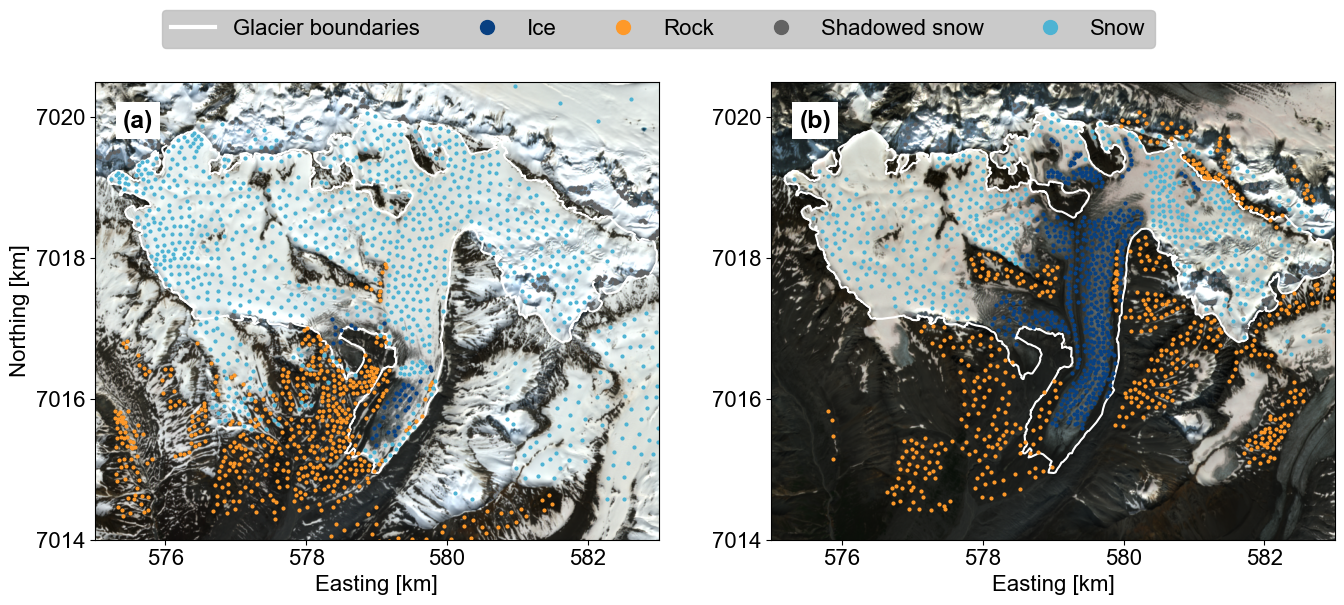

figure saved to file: /Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/figures/fig03_example_training_points.png


In [58]:
from shapely.geometry import Polygon, MultiPolygon

data_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/manually-classified-points/Sentinel-2/'
im_dates = ['20210615', '20210802']
site_name = 'Gulkana'

# load glacier outlines from file
study_sites_path = '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/'
AOI_fn = study_sites_path + 'Gulkana/AOIs/Gulkana_USGS_glacier_outline_2021.shp'
AOI = gpd.read_file(AOI_fn)
AOI_color = 'w'

# grab Sentinel-2_SR image file name
os.chdir(data_path)
im_fns = ['Gulkana_20210615T211519_20210615T211514_T06VWR.tif', 'Gulkana_20210802T212531_20210802T212655_T06VWR.tif']

# set up figure
fontsize = 16
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(1, 2, figsize=(16,8))
text_labels = ['(a)', '(b)']

# iterate over images
for i, (im_date, im_fn) in enumerate(zip(im_dates, im_fns)):
    im = rxr.open_rasterio(im_fn)
    # grab CRS
    crs = im.rio.crs.to_epsg()
    im = im / 1e4
    AOI = AOI.to_crs(crs)

    # grab validation point names
    data_pts_fns = sorted(glob.glob(site_name + '*' + im_date + '*.shp'))

    # Plot
    # RGB image
    ax[i].imshow(np.dstack([im.data[3], im.data[2], im.data[1]]), 
                           extent=(np.min(im.x.data)/1e3, np.max(im.x.data)/1e3,
                                   np.min(im.y.data)/1e3, np.max(im.y.data)/1e3))
    # Glacier boundary
    if type(AOI.geometry[0])==MultiPolygon:
        for j, geom in enumerate(AOI.geometry[0].geoms):
            if j==0:
                ax[i].plot(np.divide(geom.exterior.coords.xy[0], 1e3), np.divide(geom.exterior.coords.xy[1], 1e3), 
                           '-', linewidth=2, color=AOI_color, label='Glacier boundaries')
            else:
                ax[i].plot(np.divide(geom.exterior.coords.xy[0], 1e3), np.divide(geom.exterior.coords.xy[1], 1e3), 
                           '-', linewidth=2, color=AOI_color, label='_nolegend')
    else:
        ax[i].plot(np.divide(AOI.geometry[0].exterior.coords.xy[0], 1e3), np.divide(AOI.geometry[0].exterior.coords.xy[1], 1e3),
                   '-', color=AOI_color, label='Glacier boundaries')
    # Classified points
    for data_pts_fn in data_pts_fns:
        data_pts = gpd.read_file(data_pts_fn)
        data_pts = data_pts.to_crs(crs)
        if 'snow.' in data_pts_fn:
            color = colors_classified[0]
            label = 'Snow'
        elif 'snow-shadowed' in data_pts_fn:
            color = colors_classified[1]
            label = 'Shadowed snow'
        elif 'ice' in data_pts_fn:
            color = colors_classified[2]
            label = 'Ice'
        elif 'rock' in data_pts_fn:
            color = colors_classified[3]
            label = 'Rock'
        elif 'water' in data_pts_fn:
            color = colors_classified[4]
            label = 'Water'
        for j, point in enumerate(data_pts['geometry'].values):
            if j==0:
                legend_label = label
            else:
                legend_label = '_nolegend'
            ax[i].plot(np.divide(point.geoms[0].coords.xy[0], 1e3), np.divide(point.geoms[0].coords.xy[1], 1e3), 
                       '.', color=color, markersize=4, label=legend_label)

        ax[i].set_xlim(575, 583)
        ax[i].set_ylim(7014, 7020.5)
    # text label
    ax[i].text((ax[i].get_xlim()[1] - ax[i].get_xlim()[0]) * 0.05 + ax[i].get_xlim()[0], 
               (ax[i].get_ylim()[1] - ax[i].get_ylim()[0]) * 0.9 + ax[i].get_ylim()[0],
               text_labels[i], fontsize=fontsize+2, fontweight='bold', bbox=dict(facecolor='white', edgecolor='none', pad=5))
    # axes ticks
    ax[i].set_xticks(np.arange(576, 583, 2))
    ax[i].set_yticks(np.arange(7014, 7021, 2))
        
ax[0].set_xlabel('Easting [km]')
ax[0].set_ylabel('Northing [km]')
ax[1].set_xlabel('Easting [km]')
legend = ax[1].legend(loc='lower right', bbox_to_anchor=[0.5, 1.05, 0.2, 0.2], markerscale=5, ncols=5, frameon=1)
for line in legend.get_lines():
    line.set_linewidth(3.0)
frame = legend.get_frame()
frame.set_color('#bdbdbd')
plt.show()

# save figure
if save_figures:
    fig_fn = os.path.join(figures_out_path, 'fig03_example_training_points.png')
    fig.savefig(fig_fn, dpi=250, facecolor='white', edgecolor='none', bbox_inches='tight')
    print('figure saved to file: ' + fig_fn)

## Figure 4. Methods workflow

In [ ]:
font_size = 32
save_figures = 1

# -----Load dataset dictionary
with open(base_path + 'inputs-outputs/datasets_characteristics.json') as fn:
    dataset_dict = json.load(fn)
dataset = 'PlanetScope'

# -----Image settings
# site name
site_name = 'SouthCascade'
# create colormap for classified image
cmp = ListedColormap(colors_classified)

# -----Load AOI as gpd.GeoDataFrame
AOI_fn = study_sites_path + site_name + '/AOIs/' + site_name + '_USGS_*.shp'
AOI_fn = glob.glob(AOI_fn)[0]
AOI = gpd.read_file(AOI_fn)
# reproject the AOI to WGS to solve for the optimal UTM zone
AOI_WGS = AOI.to_crs(4326)
AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
# reproject AOI to UTM
AOI_UTM = AOI.to_crs(str(epsg_UTM))

# -----Load DEM as Xarray DataSet
DEM_fn = study_sites_path + site_name + '/DEMs/' + site_name + '*_DEM*.tif'
# load DEM as xarray DataSet
DEM_fn = glob.glob(DEM_fn)[0]
DEM = xr.open_dataset(DEM_fn)
DEM = DEM.rename({'band_data': 'elevation'})
# reproject the DEM to the optimal UTM zone
DEM = DEM.rio.reproject(str('EPSG:'+epsg_UTM))
# remove unnecessary data (possible extra bands from ArcticDEM or other DEM)
if len(np.shape(DEM.elevation.data))>2:
    DEM['elevation'] = DEM.elevation[0]
    
# -----1. Raw image
im_path = study_sites_path + site_name + '/imagery/PlanetScope/mosaics/'
im_fn = '20210924_18.tif'
im = xr.open_dataset(im_path + im_fn)
# determine image date from image mosaic file name
im_date = im_fn[0:4] + '-' + im_fn[4:6] + '-' + im_fn[6:8] + 'T' + im_fn[9:11] + ':00:00'
im_dt = np.datetime64(im_date)
xmin, xmax, ymin, ymax = np.min(im.x.data), np.max(im.x.data), np.min(im.y.data), np.max(im.y.data)
# plot
fig1, ax1 = plt.subplots(figsize=(8,8))
ax1.imshow(np.dstack([im.band_data.data[2]/1e4, im.band_data.data[1]/1e4, im.band_data.data[0]/1e4]), 
           extent=(xmin, xmax, ymin, ymax))
AOI.plot(ax=ax1, facecolor='none', edgecolor='k', linewidth=3)
ax1.set_xlim(xmin, xmax)
ax1.set_ylim(ymin, ymax)
ax1.axis('off')

# -----2. Adjusted image
polygon_top, polygon_bottom = f.create_aoi_elev_polys(AOI_UTM, DEM)
im_adj, im_adj_method = f.planetscope_adjust_image_radiometry(im, im_dt, polygon_top, polygon_bottom, dataset_dict, skip_clipped=False)
# plot
fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.imshow(np.dstack([im_adj.Red.data[0], im_adj.Green.data[0], im_adj.Blue.data[0]]), 
           extent=(xmin, xmax, ymin, ymax))
AOI_UTM.plot(ax=ax2, facecolor='none', edgecolor='k', linewidth=3)
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.axis('off')

# -----3. Classified image
im_classified_path = study_sites_path + site_name + '/imagery/classified/'
im_classified_fn = '20210924T180000_SouthCascade_PlanetScope_classified.nc'
im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
# remove no data values
im_classified = xr.where(im_classified==-9999, np.nan, im_classified)
# plot
fig3, ax3 = plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size':font_size, 'font.sans-serif':'Arial'})
ax3.imshow(im_classified.classified.data[0], cmap=cmp, vmin=1, vmax=5,
           extent=(xmin, xmax, ymin, ymax))
AOI.plot(ax=ax3, facecolor='none', edgecolor='k', linewidth=3)
# plot dummy points for legend
ax3.scatter(0, 0, marker='s', color=colors_classified[0], s=300, label='snow')
ax3.scatter(0, 0, marker='s', color=colors_classified[1], s=300, label='shadowed snow')
ax3.scatter(0, 0, marker='s', color=colors_classified[2], s=300, label='ice')
ax3.scatter(0, 0, marker='s', color=colors_classified[3], s=300, label='rock')
ax3.scatter(0, 0, marker='s', color=colors_classified[4], s=300, label='water')
ax3.set_xlim(xmin, xmax+300)
ax3.set_ylim(ymin, ymax)
ax3.legend(loc='center right', bbox_to_anchor=[1.3, 0.7, 0.2, 0.2])
ax3.axis('off')

# -----4. Snow edges
# create binary snow matrix
im_binary = xr.where(im_classified.classified.data[0] <=2, 1, 0)
# Find contours at a constant value of 0.5 (between 0 and 1)
contours = find_contours(im_binary, 0.5)
# convert contour points to image coordinates
contours_coords = []
for contour in contours: 
    ix = np.round(contour[:,1]).astype(int)
    iy = np.round(contour[:,0]).astype(int)
    coords = (im_adj.isel(x=ix, y=iy).x.data, # image x coordinates
              im_adj.isel(x=ix, y=iy).y.data) # image y coordinates
    # zip points together
    xy = list(zip([x for x in coords[0]], 
                  [y for y in coords[1]]))
    contours_coords = contours_coords + [xy]
# plot
fig4, ax4 = plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size':font_size, 'font.sans-serif':'Arial'})
binary_plt = ax4.imshow(im_binary, cmap='Greys')
for i, contour in list(zip(np.arange(0,len(contours)), contours)):
    if i==0:
        plt.plot(contour[:,1], contour[:,0], '-c', label='edges', linewidth=2)
    else:
        plt.plot(contour[:,1], contour[:,0], '-c', label='_nolegend', linewidth=2)
# plot dummy points for legend
ax4.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='k', s=100, label='snow')
ax4.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='w', s=100, label='no snow')
ax4.set_xlim(0,len(im.x.data)+300)
ax4.set_ylim(len(im.y.data), 0)
ax4.legend(loc='upper right', bbox_to_anchor=[0.9, 0.8, 0.2, 0.2])
ax4.axis('off')

# -----5. Snow line
snowlines_fn = study_sites_path + site_name + '/imagery/snowlines/20210924T180000_SouthCascade_PlanetScope_snowline.csv'
snowlines = pd.read_csv(snowlines_fn)
snowlines_X = snowlines.snowlines_coords_X.apply(literal_eval)[0]
snowlines_Y = snowlines.snowlines_coords_Y.apply(literal_eval)[0]

# plot
fig5, ax5 = plt.subplots(figsize=(8,8))
plt.rcParams.update({'font.size':font_size, 'font.sans-serif':'Arial'})
binary_plt = ax5.imshow(im_binary, 
                        extent=(xmin, xmax, ymin, ymax),
                        cmap='Greys')
ax5.plot(snowlines_X, snowlines_Y, '.m', label='_nolegend', markersize=10)
ax5.plot(-20, -20, 'm', label='snowline', linewidth=5)
# plot dummy points for legend
ax5.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='k', s=100, label='snow')
ax5.scatter(np.array([-10, -9]),np.array([-10, -9]), edgecolor='k', facecolor='w', s=100, label='no snow')
ax5.set_xlim(xmin, xmax+300)
ax5.set_ylim(ymin, ymax)
ax5.legend(loc='center right', bbox_to_anchor=[1.0, 0.6, 0.2, 0.2])
ax5.axis('off')
plt.show()

if save_figures:
    fig_fns = ['methods_workflow_1.png', 'methods_workflow_2.png', 'methods_workflow_3.png', 
               'methods_workflow_4.png', 'methods_workflow_5.png']
    for fig_fn, fig in list(zip(fig_fns, [fig1, fig2, fig3, fig4, fig5])):
        fig_fn = os.path.join(figures_out_path, fig_fn)
        fig.savefig(fig_fn, dpi=300, facecolor='white', edgecolor='none', bbox_inches='tight')
        print('figure saved to file: ' + fig_fn)

## Figures S3 and 5. Timseries of SCA, weekly median trends for SCA, AAR, and median snowline elevations for the USGS Benchmark Glaciers

In [60]:
# -----Define site names
site_names = ['Gulkana', 'Wolverine', 'LemonCreek', 'Sperry', 'SouthCascade']

# -----Load and compile snowlines
sl_ests_full = pd.DataFrame()
for site_name in site_names:

    print(site_name)
    
    # load estimated snowlines  
    sl_est_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/Aberle_et_al_dataset_submission/' + site_name + '/imagery/snowlines/'
    sl_est_fns = glob.glob(os.path.join(sl_est_path, '*snowline.csv'))
    sl_ests = pd.DataFrame()
    for sl_est_fn in sl_est_fns:
        sl_est = pd.read_csv(sl_est_fn)
        sl_ests = pd.concat([sl_ests, sl_est])
    sl_ests.reset_index(drop=True, inplace=True)
    sl_ests['datetime'] = pd.to_datetime(sl_ests['datetime'], format='mixed')

    # concatenate to full df
    sl_ests_full = pd.concat([sl_ests_full, sl_ests])

# reset index, add year and week columns
sl_ests_full.reset_index(drop=True, inplace=True)
sl_ests_full['Year'] = sl_ests_full['datetime'].dt.year
sl_ests_full['Week'] = sl_ests_full['datetime'].dt.isocalendar().week
sl_ests_full

Gulkana
Wolverine
LemonCreek


KeyError: 'datetime'

In [ ]:
# -----Settings and display parameters
site_names = ['Gulkana', 'Wolverine', 'LemonCreek', 'Sperry', 'SouthCascade']
site_names_display = [x.replace('C', ' C') for x in site_names]
text_labels1 = ['(a)', '(b)', '(c)', '(d)', '(e)']
text_labels2 = [['(a)', '(b)', '(c)'], ['(d)', '(e)', '(f)'], ['(g)', '(h)', '(i)'], ['(j)', '(k)', '(l)'], ['(m)', '(n)', '(o)']]

# -----Set up figures
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
# time series: SCA
fig1, ax1 = plt.subplots(5, 1, figsize=(10, 12))
# weekly median trends: SCA, AAR, median snowline elevation
fig2, ax2 = plt.subplots(5, 3, figsize=(10, 12))
# fmt_year = matplotlib.dates.YearLocator() # minor ticks every year
fmt_year = matplotlib.dates.DateFormatter("%Y")
alpha = 0.9
color_sca, color_aar, color_snowline = colors_classified[0], '#FFC107', '#FB65FB'

# -----Loop through sites
for site_name, site_name_display, text_label, i in list(zip(site_names, site_names_display, text_labels1, np.arange(0,len(site_names)))):
    
    print(site_name)
    
    # subset snowlines
    sl_ests = sl_ests_full.loc[sl_ests_full['site_name']==site_name].reset_index(drop=True)
    sl_ests = sl_ests.sort_values(by='datetime')
        
    # -----Define axis limits
    xmin, xmax = np.datetime64('2013-05-01T00:00:00'), np.datetime64('2022-12-01T00:00:00')
    sl_elev_median_min = np.nanmin(sl_ests['snowline_elevs_median_m'])
    sl_elev_median_max = np.nanmax(sl_ests['snowline_elevs_median_m'])
    yrange1 = [np.nanmax(sl_ests['SCA_m2']) * 1e-6 * -0.1, np.nanmax(sl_ests['SCA_m2']) * 1e-6 * 1.1]
    yrange2_sca = yrange1
    yrange2_aar = [-0.1, 1.1]
    min_snowline_elev, max_snowline_elev = np.nanmin(sl_ests['snowline_elevs_median_m']), np.nanmax(sl_ests['snowline_elevs_median_m'])
    yrange2_snowline = [min_snowline_elev * 0.97, max_snowline_elev * 1.02]

    # -----Plot light grey boxes where no observations exist on SCA plots
    years = np.arange(2013, 2022, step=1)
    for year in years:
        min_date, max_date = np.datetime64(str(year) + '-11-01'), np.datetime64(str(year+1) + '-05-01')
        rect = matplotlib.patches.Rectangle((min_date, yrange1[0]), width=max_date-min_date, height=yrange1[1]-yrange1[0], color='#d9d9d9')
        ax1[i].add_patch(rect)
        
    # -----Plot SCA time series
    # PlanetScope
    ax1[i].plot(sl_ests['datetime'].loc[sl_ests['dataset']=='PlanetScope'], 
                np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset']=='PlanetScope'].values, 1e6), 
                '.', markeredgecolor='w', markerfacecolor=color_PlanetScope, 
                alpha=alpha, markersize=8, markeredgewidth=1, label='PlanetScope')
    # Sentinel-2 SR
    ax1[i].plot(sl_ests['datetime'].loc[sl_ests['dataset']=='Sentinel-2_SR'], 
                np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset']=='Sentinel-2_SR'].values, 1e6), 
                'D', markeredgecolor='w', markerfacecolor=color_Sentinel2, 
                alpha=alpha, markersize=4, markeredgewidth=1, label='Sentinel-2 SR')
    # Sentinel-2 TOA
    ax1[i].plot(sl_ests['datetime'].loc[sl_ests['dataset']=='Sentinel-2_TOA'], 
                np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset']=='Sentinel-2_TOA'].values, 1e6), 
                'D', markeredgecolor=color_Sentinel2, markerfacecolor='None', 
                alpha=alpha, markersize=3, markeredgewidth=1.2, label='Sentinel-2 TOA')  
    # Landsat
    ax1[i].plot(sl_ests['datetime'].loc[sl_ests['dataset']=='Landsat'], 
                np.divide(sl_ests['SCA_m2'].loc[sl_ests['dataset']=='Landsat'].values, 1e6), 
                '^', markeredgecolor='w', markerfacecolor=color_Landsat, 
                alpha=alpha, markersize=6, markeredgewidth=1, label='Landsat')       

    # -----Plot glacier area on SCA plots
    AOI_fn = glob.glob(os.path.join(study_sites_path, site_name, 'AOIs', site_name + '*USGS*.shp'))[0]
    AOI = gpd.read_file(AOI_fn)
    ax1[i].plot([xmin, xmax], [AOI.geometry[0].area / 1e6, AOI.geometry[0].area / 1e6], '--', color='grey')
    ax2[i,0].plot([15, 45], [AOI.geometry[0].area / 1e6, AOI.geometry[0].area / 1e6], '--', color='grey')

    # -----Plot min and max elevations on snowline plots
    ax2[i,2].plot([15, 45], [min_snowline_elev, min_snowline_elev], '--', color='grey')
    ax2[i,2].plot([15, 45], [max_snowline_elev, max_snowline_elev], '--', color='grey')
    
    # -----Adjust axes display settings
    ax1[i].set_xlim(xmin, xmax)
    ax1[i].set_ylim(yrange1[0], yrange1[1])
    ax1[i].xaxis.set_major_formatter(fmt_year)
    ax1[i].grid(True)
    ax1[i].text(np.datetime64('2013-06-01'),
                (ax1[i].get_ylim()[1] - ax1[i].get_ylim()[0]) * 0.06 + ax1[i].get_ylim()[0],
                text_label + ' ' + site_name_display + ' (N=' + str(len(sl_ests)) + ')',
                bbox=dict(facecolor='white', edgecolor='black', pad=5))
    if site_name=='SouthCascade':
        ax1[i].set_yticks(np.arange(0, 2.4, step=0.4))
    if i==2:
        ax1[i].set_ylabel('Snow-covered area [km$^2$]', fontsize=fontsize+2)
    ax2[i,0].set_ylabel(site_name_display)
        
    # -----Calculate median and interquartile ranges for weekly trends
    q1, q3 = 0.25, 0.75 # define quartiles
    # calculate weekly trends using only Sentinel-2 snowlines
    sl_ests_noPS = sl_ests.loc[sl_ests['dataset']!='PlanetScope']   
    for ax, column, color, yrange, ylabel in list(zip([ax2[i,0], ax2[i,1], ax2[i,2]], 
                                                      ['SCA_m2', 'AAR', 'snowline_elevs_median_m'],
                                                      [color_sca, color_aar, color_snowline],
                                                      [yrange2_sca, yrange2_aar, yrange2_snowline],
                                                      ['SCA [km$^2$]', 'Transient AAR', 'Median snowline altitude [m]'])):
        weekly = sl_ests_noPS.groupby(by='Week')[column].agg(['median', lambda x: x.quantile(q1), lambda x: x.quantile(q3)])
        weekly.columns = ['Median', 'Q1', 'Q3'] # Rename the columns for clarity
        weekly.index = weekly.index.astype(float)
        # plot
        if column=='SCA_m2':
            weekly = weekly / 1e6  # convert from m^2 to km^2
        ax.fill_between(weekly.index, weekly['Q1'], weekly['Q3'].values, color=color, alpha=0.5)
        ax.plot(weekly.index, weekly['Median'], color=color, linewidth=2)
        ax.grid(True)
        # adjust x axis
        ax.set_xlim(15, 45)
        ax.set_xticks([18, 31, 44])
        ax.set_xticklabels([])
        if i==len(site_names)-1:
            ax.set_xticklabels(['May', 'Aug', 'Nov'])
        # adjust y axis
        ax.set_ylim(yrange[0], yrange[1])
        # if column=='SCA_m2':
        #     ax.set_xticks(
        if column=='AAR':
            ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
            ax.set_yticklabels(['0.0', '', '0.5', '', '1.0'])
        if i==0:
            ax.set_title(ylabel)

# -----Add text labels to figure 2
for i in np.arange(0,len(site_names)):
    for j in np.arange(0, 3):
        ax2[i,j].text((ax2[i,j].get_xlim()[1] - ax2[i,j].get_xlim()[0]) * 0.05 + ax2[i,j].get_xlim()[0],
                      (ax2[i,j].get_ylim()[1] - ax2[i,j].get_ylim()[0]) * 0.15 + ax2[i,j].get_ylim()[0],
                      text_labels2[i][j], fontweight='bold', fontsize=fontsize+2,
                      bbox=dict(facecolor='white', edgecolor='None', pad=5))

# -----Add legend to figure 1
ax1[0].legend(loc='center', bbox_to_anchor=(0.5, 1.1), handletextpad=0.1, labelspacing=0.5, markerscale=2, ncol=4)

fig1.tight_layout()
fig2.tight_layout()
plt.show()

# -----Save figures
if save_figures:
    fig1_fn = os.path.join(figures_out_path, 'figS3_timeseries_SCA.png')
    fig1.savefig(fig1_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('figure 1 saved to file: ' + fig1_fn)
    fig2_fn = os.path.join(figures_out_path, 'fig05_weekly_median_trends_no_PlanetScope.png')
    fig2.savefig(fig2_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('figure 2 saved to file: ' + fig2_fn)

### Testing other plots... weekly medians excluding PlanetScope

In [ ]:
fig, ax = plt.subplots(len(site_names), 1, figsize=(10, 18))
cmap = matplotlib.cm.viridis

for i, site_name in enumerate(site_names):
    sl_ests = sl_ests_full.loc[sl_ests_full['site_name']==site_name].reset_index(drop=True)
    sl_ests_noPS = sl_ests.loc[sl_ests['dataset']!='PlanetScope']
    years = [2017, 2018, 2019, 2020, 2021, 2022]
    for j, year in enumerate(years):
        sl_ests_year = sl_ests_noPS.loc[sl_ests['Year']==year]
        sl_ests_year_weekly_median = sl_ests_year.groupby('Week')['SCA_m2'].mean()
        # ax[i].plot(sl_ests_year_weekly_median.index.values, np.divide(sl_ests_year_weekly_median.values, 1e6), 
        #         '.-', color=cmap(j/len(unique_years)), label=year)
        # convert year and week to date for plotting
        weekly_median = pd.DataFrame({'Week': sl_ests_year_weekly_median.index.values,
                                      'SCA_m2': sl_ests_year_weekly_median.values,
                                      'Formatted Date': year * 1000 + sl_ests_year_weekly_median.index * 10})
        weekly_median['date'] = pd.to_datetime(weekly_median['Formatted Date'], format='%Y%W%w')
        ax[i].plot(weekly_median['date'], np.divide(weekly_median['SCA_m2'], 1e6), '.-', color=cmap(j/len(years)))

    ax[i].set_ylabel('Snow-covered area [km$^2$]')
    ax[i].grid()
    

plt.show()

In [ ]:
# Plot only USGS ELAs over time
usgs_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/GIS_data/USGS/benchmarkGlacier_massBalance/'
fig = plt.figure(figsize=(12,8))
col = plt.cm.viridis
for i, site_name in enumerate(site_names):
    usgs_fn = usgs_path + site_name+'/Output_'+site_name+'_Glacier_Wide_solutions_calibrated.csv'
    usgs_file = pd.read_csv(usgs_fn)
    ELA = usgs_file['ELA']
    ELA_date = usgs_file['Ba_Date'].astype('datetime64[ns]')
    plt.plot(ELA_date, ELA, '.-', color=col((i+1)/len(site_names)), label=site_name)
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Print stats for SCA

# -----Loop through sites
for site_name in site_names:
    
    print(site_name)
    
    # load estimated snow lines  
    sl_est_fns = glob.glob(study_sites_path + site_name + '/imagery/snowlines/*snowline.csv')
    sl_ests = gpd.GeoDataFrame()
    for sl_est_fn in sl_est_fns:
        sl_est = pd.read_csv(sl_est_fn)
        sl_ests = pd.concat([sl_ests, sl_est])
    sl_ests.reset_index(drop=True, inplace=True)
    sl_ests['datetime'] = pd.to_datetime(sl_ests['datetime'], format='mixed')
    
    # identify min and max SCAs
    imin = np.argwhere(sl_ests['SCA_m2'].values==np.nanmin(sl_ests['SCA_m2'].values))[0][0]
    SCA_min, SCA_min_date = sl_ests.iloc[imin]['SCA_m2'], sl_ests.iloc[imin]['datetime']
    print('Minimum SCA: ' + str(SCA_min) + ' m^2 on ' + str(SCA_min_date))
    imax = np.argwhere(sl_ests['SCA_m2'].values==np.nanmax(sl_ests['SCA_m2'].values))[0][0]
    SCA_max, SCA_max_date = sl_ests.iloc[imax]['SCA_m2'], sl_ests.iloc[imax]['datetime']
    print('Maximum SCA: ' + str(SCA_max) + ' m^2 on ' + str(SCA_max_date)       )  
    print(' ')
          

## Figure 6. Example shortcomings and successes

In [71]:
# -----Initialize GEE
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

# -----Query GEE for images
im_dates = ['20190820T125044', '20190808T212744', '20190731T125046', '20190706T211748']
im_site_names = ['Sperry', 'Gulkana', 'Sperry', 'Gulkana']
im_datasets = ['Sentinel-2_TOA', 'Sentinel-2_SR', 'Sentinel-2_SR', 'Sentinel-2_SR']
data_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/Aberle_et_al_dataset_submission/'
AOIs_UTM = []
epsg_UTMs = []
ims_ds = []
for im_date, site_name, dataset in zip(im_dates, im_site_names, im_datasets):
    # load AOI
    AOI_path =  os.path.join(data_path, site_name, 'AOIs')
    AOI_fn = sorted(glob.glob(os.path.join(AOI_path, '*Glacier_Boundaries_*.shp')))[-1]
    AOI = gpd.read_file(AOI_fn)
    AOI_WGS = AOI.to_crs('EPSG:4326')
    # solve for optimal UTM zone
    AOI_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
    epsg_UTM = f.convert_wgs_to_utm(AOI_centroid[0], AOI_centroid[1])
    epsg_UTMs.append(epsg_UTM)
    AOI_UTM = AOI_WGS.to_crs('EPSG:' + epsg_UTM)
    AOIs_UTM.append(AOI_UTM)  # append to list of AOIs
    
    # query GEE for imagery
    im_dt = np.datetime64(im_date[0:4] + '-' + im_date[4:6] + '-' + im_date[6:8])
    date_start, date_end = str(im_dt), str(im_dt + np.timedelta64(1, 'D'))
    month_start, month_end = 1, 12
    cloud_cover_max = 100
    mask_clouds=True
    im_ds = f.query_gee_for_imagery(dataset_dict, dataset, AOI_UTM, date_start, date_end, month_start, month_end, 
                                    cloud_cover_max, mask_clouds)[0]
    # reproject to UTM
    im_ds = im_ds.rio.reproject('EPSG:' + epsg_UTM)
    ims_ds.append(im_ds)  # append to list of images
    

No image downloads necessary, Sentinel-2_TOA images over the AOI are within the GEE limit.


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/168k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/211k [00:00<?, ?iB/s]

No image downloads necessary, Sentinel-2_SR images over the AOI are within the GEE limit.


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/4.36M [00:00<?, ?iB/s]

No image downloads necessary, Sentinel-2_SR images over the AOI are within the GEE limit.


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/175k [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/218k [00:00<?, ?iB/s]

No image downloads necessary, Sentinel-2_SR images over the AOI are within the GEE limit.


  0%|          | 0/1 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/4.36M [00:00<?, ?iB/s]

IndexError: list index out of range

/Users/raineyaberle/opt/anaconda3/envs/snow-cover-mapping/lib/python3.11/site-packages/matplotlib/cm.py:489: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


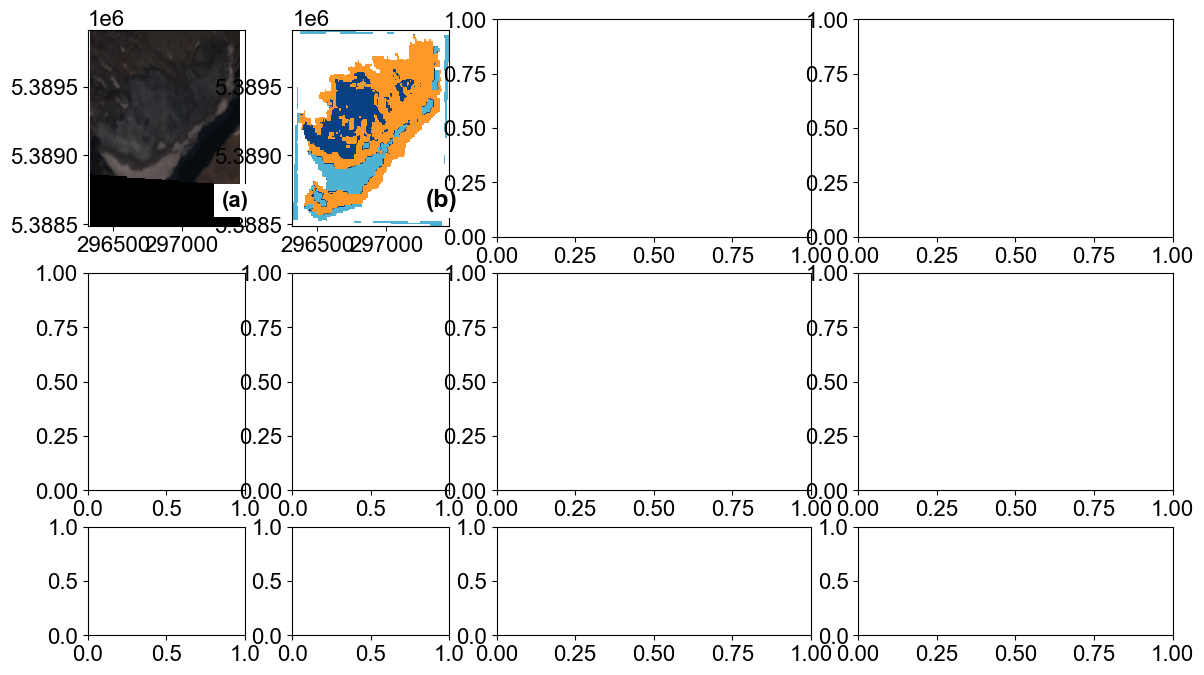

In [68]:
# -----Set up figure
fontsize = 16
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(3, 4, figsize=(14,8), gridspec_kw={'width_ratios':[1, 1, 2, 2], 'height_ratios':[1, 1, 0.5]})
ax = ax.flatten()
text_labels = [['(a)', '(b)'], ['(c)', '(d)'], ['(e)', '(f)'], ['(g)', '(h)']]

data_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/write-ups/CH1_snow_cover_mapping_methods_manuscript/Aberle_et_al_dataset_submission/'

# -----Iterate over images
for i, (im_date, site_name, dataset, text_label, AOI, epsg_UTM, im_ds) in enumerate(zip(im_dates, im_site_names, 
                                                                              im_datasets, text_labels, AOIs_UTM, epsg_UTMs, ims_ds)):
        
    # classified image
    im_classified_path = os.path.join(data_path, site_name, 'imagery', 'classified')
    im_classified_fn = glob.glob(os.path.join(im_classified_path, im_date + '_' + site_name + '_' + dataset + '*.nc'))[0]
    im_classified = xr.open_dataset(im_classified_fn)
    im_classified = xr.where((im_classified < 1e3) & (im_classified != -9999), im_classified, np.nan)
    im_classified = im_classified.rio.write_crs('EPSG:4326')
    # snowline
    sl_path = os.path.join(data_path, site_name, 'imagery', 'snowlines')
    sl_fn = glob.glob(os.path.join(sl_path, im_date + '_' + site_name + '_' + dataset + '*.csv'))[0]
    sl_df = pd.read_csv(sl_fn)
    # plot RGB image
    ax[2*i].imshow(np.dstack([im_ds[dataset_dict[dataset]['RGB_bands'][0]].data[0], 
                              im_ds[dataset_dict[dataset]['RGB_bands'][1]].data[0], 
                              im_ds[dataset_dict[dataset]['RGB_bands'][2]].data[0]]),
                   extent=(np.min(im_ds.x.data), np.max(im_ds.x.data), 
                           np.min(im_ds.y.data), np.max(im_ds.y.data)))    
    # plot classified image
    im_classified = im_classified.rio.reproject('EPSG:' + epsg_UTM)
    im_classified = xr.where(im_classified < 1e3, im_classified, np.nan)
    ax[1+2*i].imshow(im_classified.classified.data[0], cmap=ListedColormap(colors_classified), clim=(1,5),
                     extent=(np.min(im_classified.x.data), np.max(im_classified.x.data), 
                             np.min(im_classified.y.data), np.max(im_classified.y.data)))
    # plot snowline
    if sl_df['geometry'][0] != '[]':
        sl_df['geometry'] = sl_df['geometry'].apply(wkt.loads)
        sl_gdf = gpd.GeoDataFrame(sl_df, crs='EPSG:4326')
        sl_gdf = sl_gdf.to_crs('EPSG:' + epsg_UTM)
        ax[2*i].plot(*sl_gdf['geometry'][0].coords.xy, '.m', markersize=1)
        ax[1+2*i].plot(*sl_gdf['geometry'][0].coords.xy, '.m', markersize=1)
    # set same limits on axes
    ax[2*i].set_xlim(ax[1+2*i].get_xlim())
    ax[2*i].set_ylim(ax[1+2*i].get_ylim())
    # add text labels
    ax[2*i].text((ax[2*i].get_xlim()[1] - ax[2*i].get_xlim()[0]) * 0.85 + ax[2*i].get_xlim()[0],
                 (ax[2*i].get_ylim()[1] - ax[2*i].get_ylim()[0]) * 0.1 + ax[2*i].get_ylim()[0],
                 text_label[0], fontweight='bold', bbox=dict(facecolor='white', edgecolor='None', pad=5))
    ax[1+2*i].text((ax[1+2*i].get_xlim()[1] - ax[1+2*i].get_xlim()[0]) * 0.85 + ax[1+2*i].get_xlim()[0],
                   (ax[1+2*i].get_ylim()[1] - ax[1+2*i].get_ylim()[0]) * 0.1 + ax[1+2*i].get_ylim()[0],
                   text_label[1], fontweight='bold', fontsize=fontsize+2,
                   bbox=dict(facecolor='white', edgecolor='None', pad=5))

# add dummy points for legend
xmin, xmax = ax[2].get_xlim()
ymin, ymax = ax[2].get_ylim()
ax[2].plot([-10, -10], [-10, -20], '-m', linewidth=3, label='snowline')
ax[2].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[0], 
             markeredgecolor='k', markeredgewidth=1, label='snow')
ax[2].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[1], 
             markeredgecolor='k', markeredgewidth=1, label='shadowed snow')
ax[2].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[2], 
             markeredgecolor='k', markeredgewidth=1, label='ice')
ax[2].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[3], 
             markeredgecolor='k', markeredgewidth=1, label='rock')
ax[2].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[4], 
             markeredgecolor='k', markeredgewidth=1, label='water')
ax[2].set_xlim(xmin, xmax)
ax[2].set_ylim(ymin, ymax)
handles, labels = ax[2].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc = (0.015, 0.0))

# add arrows to areas of interest
for axis in [ax[0], ax[1], ax[4], ax[5]]:
    axis.arrow(297.3e3, 5388.8e3, -0.15e3, 0.15e3, width=30, fill=True, edgecolor='k', facecolor='w')
for axis in [ax[2], ax[3], ax[6], ax[7]]:
    axis.arrow(581.8e3, 7020e3, -0.8e3, -0.8e3, width=100, fill=True, edgecolor='k', facecolor='w')

# remove empty axes
for axis in ax[8:]:
    axis.remove()

# remove axis ticks
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])

fig.tight_layout()
plt.show()

# save figure
if save_figures:
    fig_fn = os.path.join(figures_out_path, 
                          'fig06_example_successes+shortcomings.png')
    fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
    print('figure saved to file: ' + fig_fn)

In [70]:
sorted(os.listdir(im_classified_path))

['.DS_Store',
 '20130526T210853_Gulkana_Landsat_classified.nc',
 '20130528T205655_Gulkana_Landsat_classified.nc',
 '20130611T210850_Gulkana_Landsat_classified.nc',
 '20130627T210847_Gulkana_Landsat_classified.nc',
 '20140515T205425_Gulkana_Landsat_classified.nc',
 '20140522T210033_Gulkana_Landsat_classified.nc',
 '20140702T205439_Gulkana_Landsat_classified.nc',
 '20140927T210110_Gulkana_Landsat_classified.nc',
 '20150502T205404_Gulkana_Landsat_classified.nc',
 '20150516T210551_Gulkana_Landsat_classified.nc',
 '20150518T205354_Gulkana_Landsat_classified.nc',
 '20150921T210713_Gulkana_Landsat_classified.nc',
 '20151009T205453_Gulkana_Landsat_classified.nc',
 '20160510T212646_Gulkana_Sentinel-2_TOA_classified.nc',
 '20160511T210035_Gulkana_Landsat_classified.nc',
 '20160530T212527_Gulkana_Sentinel-2_TOA_classified.nc',
 '20160603T210654_Gulkana_Landsat_classified.nc',
 '20160927T212517_Gulkana_Sentinel-2_TOA_classified.nc',
 '20160929T200000_Gulkana_PlanetScope_classified.nc',
 '20161004T

## Figure 7. Firn detection at Wolverine

In [ ]:
# -----Initialize GEE
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

# -----Load AOI
site_name = 'Wolverine'
AOI_path = os.path.join(study_sites_path, site_name, 'AOIs')
AOI_fn = glob.glob(os.path.join(AOI_path, '*USGS*.shp'))[0]
AOI_UTM = gpd.read_file(AOI_fn)

# -----Query GEE for images
im_date = '20200822T152833'
datasets = ['Sentinel-2_TOA', 'Sentinel-2_SR']
im_ds_list = []
for dataset in datasets:
    im_dt = np.datetime64(im_date[0:4] + '-' + im_date[4:6] + '-' + im_date[6:8])
    date_start, date_end = str(im_dt), str(im_dt + np.timedelta64(1, 'D'))
    month_start, month_end = 1, 12
    cloud_cover_max = 100
    mask_clouds=True
    im_ds = f.query_gee_for_imagery(dataset_dict, dataset, AOI_UTM, date_start, date_end, month_start, month_end, cloud_cover_max, mask_clouds)[0]
    im_ds_list.append(im_ds)

In [ ]:
# -----Set up figure
fontsize = 12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig = plt.figure(figsize=(10,8))
ax = [fig.add_axes([0.05, 0.4, 0.35, 0.3]), 
      fig.add_axes([0.43, 0.4, 0.35, 0.3]),
      fig.add_axes([0.05, 0.05, 0.35, 0.3]),
      fig.add_axes([0.43, 0.05, 0.35, 0.3])
     ]

# -----Difficult conditions (unsuccessful)
im_ds = im_ds_list[0]
dataset = 'Sentinel-2_TOA'
# classified image
im_classified_path = study_sites_path + site_name + '/imagery/classified/'
im_classified_fn = glob.glob(im_classified_path + im_date + '_' + site_name + '_' + dataset + '*.nc')[0]
im_classified = xr.open_dataset(im_classified_fn)
crs = im_classified.rio.crs
im_classified = xr.where(im_classified!=-9999, im_classified, np.nan)
im_classified = im_classified.rio.write_crs(crs)
im_classified = im_classified.rio.reproject(im_ds.rio.crs)
# snowline
sl_path = study_sites_path + site_name + '/imagery/snowlines/'
sl_fn = glob.glob(sl_path + im_date + '_' + site_name + '_' + dataset + '*.csv')[0]
sl_df = pd.read_csv(sl_fn)
sl_df['geometry'] = sl_df['geometry'].apply(wkt.loads)
sl_gdf = gpd.GeoDataFrame(sl_df, crs='EPSG:4326')
sl_gdf = sl_gdf.to_crs('EPSG:' + str(im_ds.rio.crs.to_epsg()))
# plot
ax[0].imshow(np.dstack([im_ds[dataset_dict[dataset]['RGB_bands'][0]].data[0], 
                          im_ds[dataset_dict[dataset]['RGB_bands'][1]].data[0], 
                          im_ds[dataset_dict[dataset]['RGB_bands'][2]].data[0]]),
              extent=(np.min(im_ds.x.data), np.max(im_ds.x.data), 
                      np.min(im_ds.y.data), np.max(im_ds.y.data)))
im_classified = xr.where(im_classified < 1e3, im_classified, np.nan)
ax[1].imshow(im_classified.classified.data[0], cmap=ListedColormap(colors_classified), clim=(1,5),
               extent=(np.min(im_classified.x.data), np.max(im_classified.x.data), 
                       np.min(im_classified.y.data), np.max(im_classified.y.data)))
# zoom in on firn area
ax[0].set_ylim(6698*1e3, 6701.5*1e3)
ax[1].set_ylim(6698*1e3, 6701.5*1e3) 
ax[0].plot(*sl_gdf['geometry'][0].coords.xy, '.', color='orange', markersize=1)
ax[1].plot(*sl_gdf['geometry'][0].coords.xy, '.', color='orange', markersize=1)
                                        
# -----Ideal conditions (successes)
im_ds = im_ds_list[1]
dataset = 'Sentinel-2_SR'
# classified image
im_classified_path = study_sites_path + site_name + '/imagery/classified/'
im_classified_fn = glob.glob(im_classified_path + im_date + '_' + site_name + '_' + dataset + '*.nc')[0]
im_classified = xr.open_dataset(im_classified_fn)
crs = im_classified.rio.crs
im_classified = xr.where(im_classified!=-9999, im_classified, np.nan)
im_classified = im_classified.rio.write_crs(crs)
im_classified = im_classified.rio.reproject(im_ds.rio.crs)
# snowline
sl_path = study_sites_path + site_name + '/imagery/snowlines/'
sl_fn = glob.glob(sl_path + im_date + '_' + site_name + '_' + dataset + '*.csv')[0]
sl_df = pd.read_csv(sl_fn)
sl_df['geometry'] = sl_df['geometry'].apply(wkt.loads)
sl_gdf = gpd.GeoDataFrame(sl_df, crs='EPSG:4326')
im_ds = im_ds_list[1]
sl_gdf = sl_gdf.to_crs('EPSG:' + str(im_ds.rio.crs.to_epsg()))
# plot
ax[2].imshow(np.dstack([im_ds[dataset_dict[dataset]['RGB_bands'][0]].data[0], 
                          im_ds[dataset_dict[dataset]['RGB_bands'][1]].data[0], 
                          im_ds[dataset_dict[dataset]['RGB_bands'][2]].data[0]]),
              extent=(np.min(im_ds.x.data), np.max(im_ds.x.data), 
                      np.min(im_ds.y.data), np.max(im_ds.y.data)))
im_classified = xr.where(im_classified < 1e3, im_classified, np.nan)
ax[3].imshow(im_classified.classified.data[0], cmap=ListedColormap(colors_classified), clim=(1,5),
               extent=(np.min(im_classified.x.data), np.max(im_classified.x.data), 
                       np.min(im_classified.y.data), np.max(im_classified.y.data)))
ax[2].plot(*sl_gdf['geometry'][0].coords.xy, '.m', markersize=1)
ax[3].plot(*sl_gdf['geometry'][0].coords.xy, '.m', markersize=1)
# zoom in on firn area
ax[2].set_ylim(6698*1e3, 6701.5*1e3)
ax[3].set_ylim(6698*1e3, 6701.5*1e3)
 
# remove axis ticks and labels
for axis in ax:
    axis.set_xticks([])
    axis.set_yticks([])
    
# add dummy points for legend
xmin, xmax = ax[0].get_xlim()
ymin, ymax = ax[0].get_ylim()
ax[3].plot([-10, -10], [-10, -20], '-', color='orange', linewidth=3, label='Incorrect snowline')
ax[3].plot([-10, -10], [-10, -20], '-m', linewidth=3, label='Correct snowline')
ax[3].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[0], 
             markeredgecolor='k', markeredgewidth=1, label='snow')
ax[3].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[1], 
             markeredgecolor='k', markeredgewidth=1, label='shadowed snow')
ax[3].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[2], 
             markeredgecolor='k', markeredgewidth=1, label='ice')
ax[3].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[3], 
             markeredgecolor='k', markeredgewidth=1, label='rock')
ax[3].plot(-10, -10, 's', markersize=20, markerfacecolor=colors_classified[4], 
             markeredgecolor='k', markeredgewidth=1, label='water')
ax[3].set_xlim(xmin, xmax)
ax[3].set_ylim(ymin, ymax)

# add text labels and arrows indicating firn
text_labels = ['(a)', '(b)', '(c)', '(d)']
for i, axis in enumerate(ax):
    axis.text(ax[0].get_xlim()[0] + 0.89*(ax[0].get_xlim()[1] - ax[0].get_xlim()[0]),
              ax[0].get_ylim()[0] + 0.1*(ax[0].get_ylim()[1] - ax[0].get_ylim()[0]),
              text_labels[i], fontweight='bold', fontsize=fontsize+2, bbox=dict(facecolor='white', edgecolor='w', pad=5))
    axis.arrow(395*1e3, 6698.88*1e3, 0, 0.5e3, color='white', width=0.5, head_width=150, head_length=150, length_includes_head=True, zorder=10)
    axis.arrow(393.8*1e3, 6698.88*1e3, 0, 0.5e3, color='white', width=0.5, head_width=150, head_length=150, length_includes_head=True, zorder=10)
    axis.arrow(395.52*1e3, 6698.7*1e3, 0.4e3, 0.4e3, color='white', width=0.5, head_width=150, head_length=150, length_includes_head=True, zorder=10)

# add legend
handles, labels = ax[3].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc = (0.79, 0.35))
    
fig.tight_layout()
plt.show()

# -----Save figure
if save_figures:
    fig_fn = os.path.join(figures_out_path, 'fig07_example_firn_detection.png')
    fig.savefig(fig_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('figure saved to file: '+ fig_fn)

## Figure 9. South Cascade snowline cover elevations distribution

In [ ]:
ee.Initialize()
date_start, date_end = '2022-10-02', '2022-10-03'
dataset = 'Sentinel-2_SR'
site_name = 'SouthCascade'

# load AOI
AOI_fn = os.path.join(study_sites_path, site_name, 'AOIs', 'SouthCascade_USGS_glacier_outline_2021.shp')
AOI = gpd.read_file(AOI_fn)

# query GEE for image
im_xr = f.query_gee_for_imagery(dataset_dict, dataset, AOI, date_start, date_end, 
                                month_start=1, month_end=12, cloud_cover_max=70, mask_clouds=True)[0]
im_xr

In [ ]:
# load EGM96 geoid heights
egm96_fn = os.path.join(base_path, 'inputs-outputs', 'us_nga_egm96_15.tif')
egm96 = xr.open_dataset(egm96_fn)
egm96 = egm96.rename({'band_data': 'geoid_height'})

# load classified image
im_classified_fn = os.path.join(study_sites_path, site_name, 'imagery', 'classified',
                                '20221002T132103_SouthCascade_Sentinel-2_SR_classified.nc')
im_classified = xr.open_dataset(im_classified_fn)
im_classified = im_classified.rio.reproject('EPSG:'+str(AOI.crs.to_epsg()))

# load snowline
snowline_fn = os.path.join(study_sites_path, site_name, 'imagery', 'snowlines',
                           '20221002T132103_SouthCascade_Sentinel-2_SR_snowline.csv')
snowline = pd.read_csv(snowline_fn)
snowline['geometry'] = snowline['geometry'].apply(wkt.loads)
snowline_gdf = gpd.GeoDataFrame(snowline, geometry=snowline['geometry'], crs='EPSG:4326')
snowline_gdf['snowline_elevs_m'] = [pd.eval(snowline_gdf['snowline_elevs_m'][0].replace('\n','').replace(' ',', '))]
# reference elevations to the ellipsoid instead for direct comparison
geoid_heights = [egm96.sel(x=x, y=y, method='nearest').geoid_height.data[0] for x,y in 
                 list(zip(snowline_gdf.geometry[0].coords.xy[0], snowline_gdf.geometry[0].coords.xy[1]))]
snowline_elevs_m_ellipsoid = [(x+y) for x,y in list(zip(snowline_gdf['snowline_elevs_m'][0], geoid_heights))]

# load DEM
DEM_fn = os.path.join(study_sites_path, site_name, 'DEMs',
                      'SouthCascade_20210813_USGS_DEM_filled.tif')
DEM = xr.open_dataset(DEM_fn)
DEM = DEM.rio.reproject('EPSG:'+str(AOI.crs.to_epsg()))
DEM = xr.where(DEM >= 1e38, np.nan, DEM)
DEM = DEM.rio.write_crs('EPSG:'+str(AOI.crs.to_epsg()))

# clip DEM to AOI and interpolate to classified image coordinates
dem_aoi = DEM.rio.clip(AOI.geometry, AOI.crs)
dem_aoi_interp = dem_aoi.interp(x=im_classified.x.data, y=im_classified.y.data, method='linear')
# add elevation as a band to classified image for convenience
im_classified['elevation'] = (('time', 'y', 'x'), dem_aoi_interp.band_data.data)

# determine snow covered elevations
all_elev = np.ravel(dem_aoi_interp.band_data.data)
all_elev = all_elev[~np.isnan(all_elev)]  # remove NaNs
snow_est_elev = np.ravel(im_classified.where((im_classified.classified <= 2))
                         .where(im_classified.classified != -9999).elevation.data)
snow_est_elev = snow_est_elev[~np.isnan(snow_est_elev)]  # remove NaNs

# -----Create elevation histograms
# determine bins to use in histograms
elev_min = np.fix(np.nanmin(np.ravel(im_classified.elevation.data)) / 10) * 10
elev_max = np.round(np.nanmax(np.ravel(im_classified.elevation.data)) / 10) * 10
bin_edges = np.linspace(elev_min, elev_max, num=int((elev_max - elev_min) / 10 + 1))
bin_centers = (bin_edges[1:] + bin_edges[0:-1]) / 2
# calculate elevation histograms
hist_elev = np.histogram(all_elev, bins=bin_edges)[0]
hist_snow_est_elev = np.histogram(snow_est_elev, bins=bin_edges)[0]
hist_snow_est_elev_norm = hist_snow_est_elev / hist_elev

In [ ]:
from matplotlib.patches import Rectangle

# PLOT
fontsize = 18
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig, ax = plt.subplots(1, 2, figsize=(16,8))
# RGB image
xmin, xmax = np.min(im_xr.x.data)/1e3, np.max(im_xr.x.data)/1e3
ymin, ymax = np.min(im_xr.y.data)/1e3, np.max(im_xr.y.data)/1e3
ax[0].imshow(np.dstack([im_xr['B4'].data[0], im_xr['B3'].data[0], im_xr['B2'].data[0]]),
             extent=(xmin, xmax, ymin, ymax))
snowline_gdf = snowline_gdf.to_crs(snowline_gdf['HorizontalCRS'][0])
ax[0].plot(np.divide(snowline_gdf.geometry[0].coords.xy[0], 1e3), 
           np.divide(snowline_gdf.geometry[0].coords.xy[1], 1e3), '.m', markersize=2)
x_mesh, y_mesh = np.meshgrid(im_classified.x.data, im_classified.y.data)
ax[0].contour(np.divide(x_mesh, 1e3), np.divide(y_mesh, 1e3), im_classified.elevation.data[0], 
              levels=[np.nanmedian(snowline_elevs_m_ellipsoid)], colors='#ff7f00', linewidths=3)
# dummy lines for legend
ax[0].plot([0,1], [0,1], '-m', linewidth=2, label='Snowline')
ax[0].plot([0,1], [0,1], '-', color='#ff7f00', linewidth=2, label='Median snowline altitude')
ax[0].set_xlim(xmin, xmax)
ax[0].set_ylim(ymin, ymax)
ax[0].legend(loc='lower center', bbox_to_anchor=[0.4, 1.02, 0.2, 0.2], framealpha=1)
ax[0].set_xlabel('Easting [km]')
ax[0].set_ylabel('Northing [km]')
ax[0].set_yticks([5356.5, 5357, 5357.5, 5358, 5358.5])
ax[0].text((xmax-xmin)*0.08 + xmin, (ymax - ymin)*0.08 + ymin, 
           '(a)', fontweight='bold', fontsize=fontsize+2, bbox=dict(facecolor='white', pad=5))
# histograms
sl_elev_min = np.nanmin(snowline_elevs_m_ellipsoid)
sl_elev_max = np.nanmax(snowline_elevs_m_ellipsoid)
rect = Rectangle((sl_elev_min, 0), width=sl_elev_max-sl_elev_min, height=950, facecolor='m', alpha=0.2)
ax[1].add_patch(rect)
ax[1].bar(bin_centers, hist_elev, width=(bin_centers[1] - bin_centers[0]), color='#238443', 
          align='center', label='All elevations')
ax[1].bar(bin_centers, hist_snow_est_elev, width=(bin_centers[1] - bin_centers[0]), 
          color=colors_classified[0], align='center', label='Snow-covered elevations')
ax[1].plot([np.nanmedian(snowline_elevs_m_ellipsoid), np.nanmedian(snowline_elevs_m_ellipsoid)], [0, 1000], '-',
           color='#ff7f00', linewidth=3, label='Median snowline altitude')
ax[1].grid()
ax[1].set_xlabel('Elevation [m]')
ax[1].set_ylabel('Count')
ax[1].set_ylim(0, 950)
xmin, xmax = ax[1].get_xlim()
ymin, ymax = ax[1].get_ylim()
ax[1].text((xmax-xmin)*0.05 + xmin, (ymax - ymin)*0.08 + ymin, 
           '(b)', fontweight='bold', fontsize=fontsize+2, bbox=dict(facecolor='white', edgecolor='None', pad=5))
ax[1].text(1812, 900, 'Snowline elevation range', color='m', fontweight='bold', 
           bbox=dict(facecolor='w', edgecolor='None', pad=3))
ax[1].arrow(1825, 910, -50, 0, color='m', width=5, length_includes_head=True, head_length=7, head_width=25)
ax[1].arrow(2035, 910, 50, 0, color='m', width=5, length_includes_head=True, head_length=7, head_width=25)

ax[1].legend(loc='lower center', bbox_to_anchor=[0.4, 1.02, 0.2, 0.2], framealpha=1)
ax[1].set_position([0.55, 0.17, 0.5, 0.65])

plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'f09_SouthCascade_snow_covered_elevations.png')
fig.savefig(fig_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
print('figure saved to file: ' + fig_fn)

In [ ]:
# load EGM96 geoid heights
egm96_fn = os.path.join(base_path, 'inputs-outputs', 'us_nga_egm96_15.tif')
egm96 = xr.open_dataset(egm96_fn)
egm96 = egm96.rename({'band_data': 'geoid_height'})

# load classified image
im_classified_fn = os.path.join(study_sites_path, site_name, 'imagery', 'classified',
                                '20221002T132103_SouthCascade_Sentinel-2_SR_classified.nc')
im_classified = xr.open_dataset(im_classified_fn)
im_classified = im_classified.rio.reproject('EPSG:'+str(AOI.crs.to_epsg()))

# load snowline
snowline_fn = os.path.join(study_sites_path, site_name, 'imagery', 'snowlines',
                           '20221002T132103_SouthCascade_Sentinel-2_SR_snowline.csv')
snowline = pd.read_csv(snowline_fn)
snowline['geometry'] = snowline['geometry'].apply(wkt.loads)
snowline_gdf = gpd.GeoDataFrame(snowline, geometry=snowline['geometry'], crs='EPSG:4326')
snowline_gdf['snowline_elevs_m'] = [pd.eval(snowline_gdf['snowline_elevs_m'][0].replace('\n','').replace(' ',', '))]
# reference elevations to the ellipsoid instead for direct comparison
geoid_heights = [egm96.sel(x=x, y=y, method='nearest').geoid_height.data[0] for x,y in 
                 list(zip(snowline_gdf.geometry[0].coords.xy[0], snowline_gdf.geometry[0].coords.xy[1]))]
snowline_elevs_m_ellipsoid = [(x+y) for x,y in list(zip(snowline_gdf['snowline_elevs_m'][0], geoid_heights))]

## Figure S1. PlanetScope image adjustment

In [ ]:
site_name = 'LemonCreek'

# load AOI and DEM
aoi_path = os.path.join(study_sites_path, site_name, 'AOIs')
aoi_fn = glob.glob(os.path.join(aoi_path, site_name + '*USGS*.shp'))[0]
aoi = gpd.read_file(aoi_fn)
dem_path = os.path.join(study_sites_path, site_name, 'DEMs')
dem_fn = glob.glob(os.path.join(dem_path, site_name + '*USGS*.tif'))[0]
dem = xr.open_dataset(dem_fn)
dem = dem.rio.reproject('EPSG:'+str(aoi.crs.to_epsg()))
dem = dem.rename({'band_data': 'elevation'})
dem = xr.where(dem > 1e38, np.nan, dem)
dem = dem.isel(band=0)
dem = dem.rio.write_crs('EPSG:'+str(aoi.crs.to_epsg()))

# load dynamics ranges of all raw image mosaics
ps_im_path = os.path.join(study_sites_path, site_name, 'imagery', 'PlanetScope', 'mosaics')
im_fns = os.listdir(ps_im_folder)
im_fns = [x for x in im_fns if not x.startswith('.')]
dynamic_ranges = pd.DataFrame()
for im_fn in tqdm(im_fns):
    im_date = im_fn[0:4] + '-' + im_fn[4:6] + '-' + im_fn[6:8]
    im = xr.open_dataset(os.path.join(ps_im_path, im_fn))
    im = xr.where(im == -9999, np.nan, im / 1e4)
    b_min, b_max = np.nanmin(im.band_data.data[0]), np.nanmax(im.band_data.data[0])
    dynamic_range = pd.DataFrame({'date': [im_date],
                                  'b_min': [b_min],
                                  'b_max': [b_max]})
    dynamic_ranges = pd.concat([dynamic_ranges, dynamic_range])
dynamic_ranges.reset_index(drop=True, inplace=True)

# load raw image
im_date = '2020-07-29'
im_fn = glob.glob(os.path.join(ps_im_folder, im_date.replace('-','') + '*.tif'))[0]
im = xr.open_dataset(im_fn)
im = im / 1e4

# construct elevation polygons
polygon_top, polygon_bottom = psp.create_aoi_elev_polys(aoi, dem)

# adjust image radiometry
im_dt = np.datetime64(np.datetime64(im_date))
im_adj = psp.planetscope_adjust_image_radiometry(im, im_dt, polygon_top, polygon_bottom, dataset_dict, skip_clipped=False)[0]

# PLOT
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig = plt.figure(figsize=(8,12))
gs = matplotlib.gridspec.GridSpec(5, 2, figure=fig)
# dynamic ranges
ax0 = fig.add_subplot(gs[0,:])
ax0.boxplot(dynamic_ranges[['b_min', 'b_max']], vert=False, bootstrap=100)
ax0.set_xlim(0,1.5)
ax0.set_yticks([1,2])
ax0.set_yticklabels(['B$_{min}$', 'B$_{max}$'])
ax0.set_xlabel('Reflectance')
aoi_color = '#084594'
poly_color = '#41ab5d'
# original RGB image
ax1 = fig.add_subplot(gs[1:4, 0])
ax1.imshow(np.dstack([im.band_data.data[2], im.band_data.data[1], im.band_data.data[0]]),
             extent=(np.min(im.x.data)/1e3, np.max(im.x.data)/1e3, 
                     np.min(im.y.data)/1e3, np.max(im.y.data)/1e3))
for geom in aoi.geometry[0].geoms:
    aoi_line = ax1.plot(np.divide(geom.exterior.coords.xy[0], 1e3), np.divide(geom.exterior.coords.xy[1], 1e3), '-', color=aoi_color)
for geom in polygon_top.geoms:
    poly_line = ax1.plot(np.divide(geom.exterior.coords.xy[0], 1e3), np.divide(geom.exterior.coords.xy[1], 1e3), '--', color=poly_color)
ax1.set_ylabel('Northing [km]')
ax1.set_xlabel('Easting [km]')
# original band histograms
ax3 = fig.add_subplot(gs[4,0])
ax3.hist(np.ravel(im.band_data.data[3]), color='purple', bins=100, histtype='step', linewidth=2, label='NIR')
ax3.hist(np.ravel(im.band_data.data[2]), color='blue', bins=100, histtype='step', linewidth=2, label='B')
ax3.hist(np.ravel(im.band_data.data[1]), color='green', bins=100, histtype='step', linewidth=2, label='G')
ax3.hist(np.ravel(im.band_data.data[0]), color='red', bins=100, histtype='step', linewidth=2, label='R')
ax3.grid()
ax3.set_xlim(0,1.5)
ax3.set_ylim(0,1e5)
ax3.set_yticklabels([])
ax3.set_ylabel('Counts')
ax3.set_xlabel('Reflectance')
# adjusted RGB image
ax2 = fig.add_subplot(gs[1:4,1])
ax2.imshow(np.dstack([im_adj.Red.data[0], im_adj.Green.data[0], im_adj.Blue.data[0]]),
             extent=(np.min(im_adj.x.data)/1e3, np.max(im_adj.x.data)/1e3, 
                     np.min(im_adj.y.data)/1e3, np.max(im_adj.y.data)/1e3))
ax2.set_xlabel('Easting [km]')
for geom in aoi.geometry[0].geoms:
    aoi_line = ax2.plot(np.divide(geom.exterior.coords.xy[0], 1e3), np.divide(geom.exterior.coords.xy[1], 1e3), '-', color=aoi_color)
for geom in polygon_top.geoms:
    poly_line = ax2.plot(np.divide(geom.exterior.coords.xy[0], 1e3), np.divide(geom.exterior.coords.xy[1], 1e3), '--', color=poly_color)
ax2.legend([aoi_line[0], poly_line[0]], ['Glacier boundary', 'Z$_{P80}$ Polygon'], 
           loc='center right', bbox_to_anchor=[1.7, 0.5, 0.2, 0.2])
# adjusted band histograms
ax4 = fig.add_subplot(gs[4,1])
ax4.hist(np.ravel(im_adj.NIR.data[0]), color='purple', bins=100, histtype='step', linewidth=2, label='NIR')
ax4.hist(np.ravel(im_adj.Blue.data[0]), color='blue', bins=100, histtype='step', linewidth=2, label='B')
ax4.hist(np.ravel(im_adj.Green.data[0]), color='green', bins=100, histtype='step', linewidth=2, label='G')
ax4.hist(np.ravel(im_adj.Red.data[0]), color='red', bins=100, histtype='step', linewidth=2, label='R')
ax4.legend(loc='center right', bbox_to_anchor=[1.2, 0.4, 0.2, 0.2])
ax4.grid()
ax4.set_xlim(0,1.5)
ax4.set_ylim(0,1e5)
ax4.set_yticklabels([])
ax4.set_xlabel('Reflectance')
# add text labels
text_labels = ['(a)', '(b)', '(c)', '(d)', '(e)']
for ax, text_label, i in list(zip([ax0, ax1, ax2, ax3, ax4], text_labels, np.arange(0,len(text_labels)))):
    if i==0:
        xscale, yscale = 0.03, 0.8
    elif (i==1) or (i==2):
        xscale, yscale = 0.1, 0.93
    else:
        xscale, yscale = 0.05, 0.8
    ax.text((ax.get_xlim()[1] - ax.get_xlim()[0])*xscale + ax.get_xlim()[0],
            (ax.get_ylim()[1] - ax.get_ylim()[0])*yscale + ax.get_ylim()[0],
            text_label, fontweight='bold', fontsize=fontsize+2, bbox=dict(facecolor='white', edgecolor='None', pad=5))
plt.show()

# save figure
fig_fn = os.path.join(figures_out_path, 'figS1_PlanetScope_image_adjustment.png')
fig.savefig(fig_fn, dpi=300, box_inches='tight')
print('saved figure to file: ' + fig_fn)

## Figure X (removed). Testing SCA sensitivity to presence of firn

### Slope vs. area of misclassified firn %

In [ ]:
# define ranges in slopes, percents_firn, and calculate changes in SCA
slopes = np.arange(0, 51, step=0.5)
percents_firn = np.arange(0, 20.1, step=0.5)
differences = np.zeros((len(percents_firn), len(slopes)))
for i, percent_firn in enumerate(percents_firn):
    for j, slope in enumerate(slopes):
        differences[i,j] = percent_firn * np.cos(np.radians(slope))
# flip array for plotting
differences = np.array(differences)
differences = np.fliplr(np.flipud(differences))

# Plot
fontsize=14
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
fig = plt.figure(figsize=(8, 8))
# distribution of slopes
ax1 = fig.add_axes((0.1, 0.7, 0.72, 0.2))
hist = ax1.hist(rgis['Slope'].values, bins=50, color='grey', range=(0,50))
counts, bins = hist[0], hist[1]
ax1.set_xlim(0,50)
ax1.axis('off')
# heatmap of uncertainties
ax2 = fig.add_axes((0.1, 0.1, 0.9, 0.775))
diff_im = ax2.imshow(differences, extent=(slopes[0], slopes[-1], percents_firn[0], percents_firn[-1]), 
                    cmap='inferno', clim=(0,20))
ax2.set_ylabel('Misclassified firn [% of SCA]')
ax2.set_xlabel('Slope [degrees]')
ax2.set_xlim(0,50)
ax2.grid()
ax2.set_aspect(1.5)
ax2.set_yticks(np.arange(0,21, step=5))
fig.colorbar(diff_im, ax=ax2, shrink=0.5, label='$\Delta$SCA [%]', ticks=np.arange(0,21, step=5))
# add text labels
ax1.text((ax1.get_xlim()[1] - ax1.get_xlim()[0])*0.05,
         (ax1.get_ylim()[1] - ax1.get_ylim()[0])*0.1, '(a)', fontweight='bold', fontsize=fontsize+2,
         bbox=dict(facecolor='white', edgecolor='None', pad=5))
ax2.text((ax2.get_xlim()[1] - ax2.get_xlim()[0])*0.05,
         (ax2.get_ylim()[1] - ax2.get_ylim()[0])*0.1, '(b)', fontweight='bold', fontsize=fontsize+2,
         bbox=dict(facecolor='white', edgecolor='None', pad=5))
# draw box around most common slope
box_color = 'black'
I = np.argwhere(counts==np.nanmax(counts))[0][0]
rect1 = matplotlib.patches.Rectangle((bins[I], 0), width=1, height=np.nanmax(counts), edgecolor=box_color, facecolor='None')
ax1.add_patch(rect1)
rect2 = matplotlib.patches.Rectangle((bins[I], 0), width=1, height=np.nanmax(percents_firn), edgecolor=box_color, facecolor='None')
ax2.add_patch(rect2)
# add descriptor text
ax1.text(30, np.nanmax(counts)-100, 
         'Most frequent slopes = (' + str(int(bins[I])) + '\N{degree sign}, ' + str(int(bins[I+1])) + '\N{degree sign})',
         color=box_color)
ax1.text(41.1, np.nanmax(counts)-550,
         '$\Delta$SCA = (' 
         + str(int(differences[-1, np.argwhere(slopes==bins[I])[0][0]])) + '%, ' 
         + str(int(differences[0, np.argwhere(slopes==bins[I])[0][0]])) + '%)',
         color=box_color)

plt.show()

# Save figure
if save_figures:
    fig_fn = os.path.join(figures_out_path, 'figS2_sensitivity_test_misclassified_firn.png')
    fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
    print('figure saved to file: ' + fig_fn)

### Impact of slope on ELA sensitivity to air temperature change

In [ ]:
ee.Initialize()

In [ ]:
# Define image query settings
site_name = 'LemonCreek'
dataset = 'Sentinel-2_SR'
im_date = '2021-08-31'
date_start, date_end = '2021-08-31', '2021-09-01'
month_start, month_end = 7, 10
cloud_cover_max = 70
mask_clouds = False
im_out_path = None
im_download = False

# Load AOI
aoi_path = os.path.join(study_sites_path, site_name, 'AOIs')
aoi_fn = glob.glob(os.path.join(aoi_path, '*USGS*.shp'))[0]
aoi = gpd.read_file(aoi_fn)

im_list = f.query_gee_for_imagery(dataset_dict, dataset, aoi, date_start, date_end,
                                  month_start, month_end, cloud_cover_max, mask_clouds,
                                  im_out_path, im_download)
im = im_list[0]

In [ ]:
# dry adiabatic lapse rate ~= 9.8 deg C / km
# 1 deg C / (9.8 deg C / 1000 m) = 102 m / deg C increase in temp

In [ ]:
# determine whether to plot only contours
plot_contours = False

# clip image to AOI
aoi_sel = aoi.geometry[0].geoms[4]
im_clip = im

# load DEM
dem_path = os.path.join(study_sites_path, site_name, 'DEMs')
dem_fn = glob.glob(os.path.join(dem_path, '*USGS*.tif'))[0]
dem = xr.open_dataset(dem_fn)
# reproject to image CRS
dem = dem.rio.reproject('EPSG:'+str(im.rio.crs.to_epsg()))
dem = xr.where(dem < 1e38, dem, np.nan)
dem = dem.rio.write_crs('EPSG:'+str(im.rio.crs.to_epsg()))
# interpolate dem to image coordinates
dem_interp = dem.sel(x=im_clip.x.data, y=im_clip.y.data, method='nearest')
# mask it using the AOI
dem_interp_masked = dem_interp.rio.clip([aoi_sel.buffer(-80)], im.rio.crs, drop=False)
z1 = dem_interp.band_data.data[0]
z1_masked = dem_interp_masked.band_data.data[0]
# remove minimum elevation so it has a minimum of zero
z1_min = np.nanmin(z1)
z1 = z1 - z1_min
z1_masked = z1_masked - z1_min
# flip it around to match the RGB image
z1 = np.flipud(np.fliplr(z1))
z1_masked = np.flipud(np.fliplr(z1_masked))
# low slope
z2 = z1 / 2
z2_masked = z1_masked / 2

# set up RGB data
red = im_clip['B4'].data[0]
green = im_clip['B3'].data[0]
blue = im_clip['B2'].data[0]
# Ensure color values are between 0 and 1
red = np.clip(red, 0, 1)
green = np.clip(green, 0, 1)
blue = np.clip(blue, 0, 1)
# Create the RGB image 
rgb_image = np.dstack((red, green, blue))
# flip around so the glacier flows downhill
rgb_image = np.fliplr(np.flipud(rgb_image))
# Identify NaN values and set them to the specified color (white)
nan_mask = np.isnan(rgb_image).any(axis=2)
nan_color = [1, 1, 1]
rgb_image[nan_mask] = nan_color
cmap = plt.get_cmap('viridis')  # Adjust the colormap as needed
cmap.set_bad(color='white')  # Set the color for NaN values to transparent

# plot figures
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_axes((0.1, 0.1, 0.4, 0.8), projection='3d')
ax2 = fig.add_axes((0.46, 0.1, 0.4, 0.8), projection='3d')
text_labels = ['(a) High slope', '(b) Low slope']
ela_inits = 370, 180
for ax, z, z_masked, text_label, ela_init in list(zip([ax1, ax2], [z1, z2], [z1_masked, z2_masked], 
                                                      text_labels, ela_inits)):
    X, Y = np.meshgrid(dem_interp.x.data, dem_interp.y.data)
    if not plot_contours:
        ax.plot_surface(X, Y, z, rstride=1, cstride=1, alpha=1, cmap=cmap, norm=False, facecolors=rgb_image)
    # plot elevation contours
    X, Y = np.meshgrid(dem_interp_masked.x.data, dem_interp_masked.y.data)
    CS = ax.contour(X, Y, z_masked, levels=[ela_init, ela_init + 102], colors='m', alpha=1, 
                    linestyles=['solid', 'dashed'], linewidths=2) 
    # remove the axes
    ax.set_axis_off()
    ax.view_init(elev=20, azim=310)
    ax.set_zlim(0, np.nanmax(z1))
    # add text label
    ax.set_title(text_label, fontweight='bold', x=0.3, y=0.85)

# add legend for contours
if plot_contours:
    h,_ = CS.legend_elements()
    ax1.legend([h[0], h[1]], ['ELA$_1$', 'ELA$_2$'], loc='lower left')
    
plt.show()

# save figure
if save_figures:
    if plot_contours:
        fig_fn = os.path.join(figures_out_path, 'LemonCreek_3D_RGB_plot_contours.png')
        fig.savefig(fig_fn, dpi=300, bbox_inches='tight', transparent=True)
    else:
        fig_fn = os.path.join(figures_out_path, 'LemonCreek_3D_RGB_plot.png')
        fig.savefig(fig_fn, dpi=300, bbox_inches='tight')
    print('figure saved to file: ' + fig_fn)


## Figure X (removed). Images used for classification performance assessment

In [ ]:
from shapely.geometry import MultiPolygon, Polygon

data_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/classified-points/assessment/'

# grab Sentinel-2_SR image file names
os.chdir(data_path)
im_fns = sorted(glob.glob('*Sentinel-2_SR*.tif'))
# plot Lemon Creek images on top
im_fns = im_fns[2:] + im_fns[0:2]

# load glacier outlines from file
study_sites_path = '/Users/raineyaberle/Google Drive/My Drive/Research/CryoGARS-Glaciology/Advising/student-research/Alexandra-Friel/snow_cover_mapping_application/study-sites/'
AOI_fns = [study_sites_path + 'Emmons/AOIs/Emmons_RGI_outline.shp',
           study_sites_path + 'LemonCreek/AOIs/LemonCreek_USGS_glacier_outline_2021.shp']
AOIs = [gpd.read_file(AOI_fn) for AOI_fn in AOI_fns]

# grab validation point names
data_pts_fns = sorted(glob.glob('*.shp'))

# set up figure
fig, ax = plt.subplots(2, 2, figsize=(8,8))
plt.rcParams.update({'font.size':12, 'font.sans-serif':'Arial'})
ax = ax.flatten()
text_labels = ['(a)', '(b)', '(c)', '(d)']
# plot dummy points for legend
ax[0].plot(0,0, '.', markersize=8, color=colors_classified[0], label='snow')
ax[0].plot(0,0, '.', markersize=8, color=colors_classified[3], label='no snow')

# loop through image files
for i, im_fn in enumerate(im_fns):
    
    print(im_fn)
    
    # open image and plot
    im = rxr.open_rasterio(im_fn)
    # grab CRS
    crs = im.rio.crs.to_epsg()
    im = im / 1e4
    ax[i].imshow(np.dstack([im.data[3], im.data[2], im.data[1]]),
                extent=(np.min(im.x.data), np.max(im.x.data), np.min(im.y.data), np.max(im.y.data)))
    
    # load data points and plot
    site_name = im_fn.split('_')[0]
    im_date = im_fn[-12:-4]
    data_pts_snow_fn = [x for x in data_pts_fns if (site_name in x) and (im_date[0:6] in x) and ('_snow' in x)]
    if len(data_pts_snow_fn) > 0:
        data_pts_snow = gpd.read_file(data_pts_snow_fn[0])
        data_pts_snow = data_pts_snow.to_crs(im.rio.crs)
        data_pts_snow.plot(ax=ax[i], color=colors_classified[0], markersize=1)
    data_pts_no_snow_fn = [x for x in data_pts_fns if (site_name in x) and (im_date[0:6] in x) and ('no-snow' in x)]
    if len(data_pts_no_snow_fn) > 0:
        data_pts_no_snow = gpd.read_file(data_pts_no_snow_fn[0])
        data_pts_no_snow = data_pts_no_snow.to_crs(im.rio.crs)
        data_pts_no_snow.plot(ax=ax[i], color=colors_classified[3], markersize=1)
        
    # select AOI, reproject, and plot
    if 'Emmons' in im_fn:
        AOI = AOIs[0]
    elif 'LemonCreek' in im_fn:
        AOI = AOIs[1]
    AOI = AOI.to_crs('EPSG:'+str(crs))
    AOI_color = '#9e9ac8'
    if type(AOI.geometry[0])==MultiPolygon:
        for j, geom in enumerate(AOI.geometry[0].geoms):
            if j==0:
                ax[i].plot(*geom.exterior.coords.xy, '-', color=AOI_color, label='glacier boundary')
            else:
                ax[i].plot(*geom.exterior.coords.xy, '-', color=AOI_color, label='_nolegend')
    else:
        ax[i].plot(*AOI.geometry[0].exterior.coords.xy, '-', color=AOI_color, label='glacier outline')
        
    # set axis limits and ticks
    if i>=2:
        ax[i].set_xlim(593e3, 603e3)
        ax[i].set_ylim(5188e3, 5196e3)
        ax[i].set_xticks(np.arange(594e3, 603e3, step=2e3))
        ax[i].set_yticks(np.arange(5188e3, 5197e3, step=2e3))
    else:
        ax[i].set_xlim(535e3, 541e3)
        ax[i].set_ylim(6468e3, 6475e3)
        ax[i].set_xticks(np.arange(536e3, 541e3, step=2e3))
        ax[i].set_yticks(np.arange(6468e3, 6475e3, step=2e3))
    # change labels from m to km
    ax[i].set_xticklabels([str(int(x/1e3)) for x in ax[i].get_xticks()])
    ax[i].set_yticklabels([str(int(x/1e3)) for x in ax[i].get_yticks()])
        
    # add text labels
    ax[i].text((ax[i].get_xlim()[1] - ax[i].get_xlim()[0])*0.05 + ax[i].get_xlim()[0],
               (ax[i].get_ylim()[1] - ax[i].get_ylim()[0])*0.9 + ax[i].get_ylim()[0],
               text_labels[i], backgroundcolor='w')
    

# add axis labels
ax[0].set_ylabel('Northing [km]')
ax[2].set_ylabel('Northing [km]')
ax[2].set_xlabel('Easting [km]')
ax[3].set_xlabel('Easting [km]')

# add legendwin
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.27, 0.92), ncols=3)

# fig.tight_layout()
plt.show()
    
# save figure
if save_figures:
    fig_fn = os.path.join(figures_out_path, 'f04_classification_performance_assessment_images.png')
    fig.savefig(fig_fn, facecolor='w', dpi=300, bbox_inches='tight')
    print('figure saved to file: ' + fig_fn)
    

## Figure X (removed). SCA, snowlines, and AAR time series variability

In [ ]:
# -----Settings and display parameters
site_names = ['Wolverine', 'Gulkana', 'LemonCreek', 'SouthCascade', 'Sperry']

fmt_month = matplotlib.dates.MonthLocator(bymonth=(5, 11)) # minor ticks every month
fmt_year = matplotlib.dates.YearLocator() # minor ticks every year

# -----Iterate over site names
stats_df = pd.DataFrame()
values_df = pd.DataFrame()
for i, site_name in enumerate(site_names):
    
    print(site_name)

    # Load estimated snow lines  
    sl_est_fns = glob.glob(study_sites_path + site_name + '/imagery/snowlines/*snowline.csv')
    sl_ests = gpd.GeoDataFrame()
    for sl_est_fn in sl_est_fns:
        sl_est = pd.read_csv(sl_est_fn)
        sl_ests = pd.concat([sl_ests, sl_est])
    sl_ests.reset_index(drop=True, inplace=True)
    sl_ests['datetime'] = pd.to_datetime(sl_ests['datetime'], format='mixed')
        
    # Define axis limits
    # xmin, xmax = np.datetime64('2016-05-01T00:00:00'), np.datetime64('2022-12-01T00:00:00')
    # sl_elev_median_min = np.nanmin(sl_ests['snowline_elevs_median_m'])
    # sl_elev_median_max = np.nanmax(sl_ests['snowline_elevs_median_m'])
    # ymin1, ymax1 = np.nanmin(sl_ests['SCA_m2']) * 1e-6 * -0.1, np.nanmax(sl_ests['SCA_m2']) * 1e-6 * 1.3
    # ymin2 = sl_elev_median_min - 0.1*(sl_elev_median_max - sl_elev_median_min)
    # ymax2 = sl_elev_median_max + 0.1*(sl_elev_median_max - sl_elev_median_min)
    # ymin3, ymax3 = -1, 125
    # yrange1, yrange2, yrange3 = [ymin1, ymax1], [ymin2, ymax2], [ymin3, ymax3]

    # Calculate monthly mean and std for Sentinel-2 time series
    def custom_rolling_stats(data, data_var, window_size, months_to_include):
        filtered_data = data[data['datetime'].dt.month.isin(months_to_include)]
        rolling_std = filtered_data[data_var].rolling(window=window_size).apply(lambda x: np.std(x))
        return rolling_std
    
    sl_ests.index = sl_ests.datetime
    sl_ests.sort_index(inplace=True) # sort chronologically
    
    # define settings for rolling stats
    time_range = pd.Timedelta(days=7) # window for rolling stats
    months_to_include = [5,6,7,8,9,10] # which months to include
    SCA_std = custom_rolling_stats(sl_ests, 'SCA_m2', int(time_range.days), months_to_include)
    sl_std = custom_rolling_stats(sl_ests, 'snowline_elevs_median_m', int(time_range.days), months_to_include)
    AAR_std = custom_rolling_stats(sl_ests, 'AAR', int(time_range.days), months_to_include)
    
    # append to dataframe
    df = pd.DataFrame({'site_name': site_name,
                       'SCA_std': SCA_std.values,
                       'SCA_std_normalized': np.divide(SCA_std, np.nanmax(sl_ests['SCA_m2'])).values,
                       'sl_std': sl_std.values,
                       'sl_std_normalized': np.divide(sl_std, (np.nanmax(sl_ests['snowline_elevs_median_m']) - np.nanmin(sl_ests['snowline_elevs_median_m']))).values,
                       'AAR_std': AAR_std.values,
                       'AAR_std_normalized': np.divide(AAR_std, np.nanmax(sl_ests['AAR'])).values,
                      })
    stats_df = pd.concat([stats_df, df])
    
# -----Adjust dataframe
# reset index, drop NaN values
stats_df.reset_index(drop=True).dropna(inplace=True)
# add display name to dataframe for plotting
stats_df['display_name'] = [x.replace('C', ' C') for x in stats_df['site_name'].values]
# adjust units for SCA (km^2) and AAR (%)
stats_df[['SCA_std']] = np.divide(stats_df[['SCA_std']], 1e6)
stats_df[['AAR_std']] = np.multiply(stats_df[['AAR_std']], 100)

# -----Plot
plt.rcParams.update({'font.size':14, 'font.sans-serif': 'Arial'})
fig, ax = plt.subplots(3, 2, figsize=(16, 16))
ax = ax.flatten()  
# define axes settings
text_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
ylabels = ['SCA [km$^2$]', 'SCA [unitless]',
           'AAR [%]', 'AAR [unitless]',
           'Median snowline altitude [m]', 'Median snowline altitude [unitless]'
           ]
data_vars = ['SCA_std', 'SCA_std_normalized', 'AAR_std', 'AAR_std_normalized', 'sl_std', 'sl_std_normalized']
colors = [colors_classified[0], colors_classified[0], 
          '#FFC107', '#FFC107',
          '#FB65FB', '#FB65FB']
ax[0].set_title('Weekly standard deviation')
ax[1].set_title('Normalized weekly standard deviation')
ax[1].set_ylim(-0.01, 0.5)
ax[2].set_ylim(-1, 50)
ax[3].set_ylim(-0.01, 0.5)
ax[5].set_ylim(-0.01, 0.5)
# iterate over axes
for axis, data_var, color, text_label, ylabel in list(zip(ax, data_vars, colors, text_labels, ylabels)):
    sns.boxplot(data=stats_df, x='display_name', y=data_var, ax=axis, color=color) 
    axis.set(xlabel=None)
    axis.set_ylabel(ylabel)
    axis.text((axis.get_xlim()[1] - axis.get_xlim()[0])*0.935 + axis.get_xlim()[0], 
               (axis.get_ylim()[1] - axis.get_ylim()[0])*0.903 + axis.get_ylim()[0], 
               text_label, bbox=dict(facecolor='white', edgecolor='black', pad=5))
    axis.set_xticks(axis.get_xticks(), axis.get_xticklabels(), rotation=20)

plt.show()

# -----Save figures
if save_figures:
    fig_fn = os.path.join(figures_out_path, 'weekly_metric_ranges.png')
    fig.savefig(fig_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('figure saved to file: ' + fig_fn)

## Example SCA time series at South Cascade Glacier for GitHub repo

In [ ]:
site_name = 'SouthCascade'

# -----Load estimated snowlines  
sl_ests_full = pd.DataFrame()    
sl_est_fns = glob.glob(study_sites_path + site_name + '/imagery/snowlines/*snowline.csv')
sl_ests = pd.DataFrame()
for sl_est_fn in sl_est_fns:
    sl_est = pd.read_csv(sl_est_fn)
    sl_ests = pd.concat([sl_ests, sl_est])
sl_ests.reset_index(drop=True, inplace=True)
sl_ests['datetime'] = pd.to_datetime(sl_ests['datetime'], format='mixed')
# reset index and add week-of-year column
sl_ests.reset_index(drop=True, inplace=True)
sl_ests['Week'] = sl_ests['datetime'].dt.isocalendar().week
# convert SCA from m2 to km2
sl_ests['SCA_km2'] = np.divide(sl_ests['SCA_m2'].values, 1e6)

# -----Set up figure
fontsize=12
plt.rcParams.update({'font.size':fontsize, 'font.sans-serif':'Arial'})
# time series: SCA
fig1, ax1 = plt.subplots(3, 2, figsize=(10, 10), gridspec_kw=dict(width_ratios=[4,1]))
# fmt_year = matplotlib.dates.YearLocator() # minor ticks every year
fmt_year = matplotlib.dates.DateFormatter("%Y")
alpha = 0.9

# -----Define axis limits
xmin, xmax = np.datetime64('2013-05-01T00:00:00'), np.datetime64('2022-12-01T00:00:00')
sl_elev_median_min = np.nanmin(sl_ests['snowline_elevs_median_m'])
sl_elev_median_max = np.nanmax(sl_ests['snowline_elevs_median_m'])
yrange1 = [np.nanmax(sl_ests['SCA_km2']) * -0.1, np.nanmax(sl_ests['SCA_km2']) * 1.1]
yrange2 = [-0.1, 1.1]
yrange3 = [np.nanmin(sl_ests['snowline_elevs_median_m']) * 0.98, np.nanmax(sl_ests['snowline_elevs_median_m']) * 1.02]
        
# -----Plot time series of SCA, AAR, and median snowline elevations
for column, ylabel, yrange, i in list(zip(['SCA_km2', 'AAR', 'snowline_elevs_median_m'],
                                          ['SCA [km$^2$]', 'AAR', 'Median snowline elevation [m]'],
                                          [yrange1, yrange2, yrange3],
                                          np.arange(0,3))):
    # PlanetScope
    ax1[i,0].plot(sl_ests['datetime'].loc[sl_ests['dataset']=='PlanetScope'], 
                   sl_ests[column].loc[sl_ests['dataset']=='PlanetScope'].values, 
                   '.', markeredgecolor='w', markerfacecolor=color_PlanetScope, 
                alpha=alpha, markersize=10, markeredgewidth=1, label='PlanetScope')
    # Sentinel-2 SR
    ax1[i,0].plot(sl_ests['datetime'].loc[sl_ests['dataset']=='Sentinel-2_SR'], 
                  sl_ests[column].loc[sl_ests['dataset']=='Sentinel-2_SR'].values, 
                  'D', markeredgecolor='w', markerfacecolor=color_Sentinel2, 
                  alpha=alpha, markersize=4, markeredgewidth=1, label='Sentinel-2 SR')
    # Sentinel-2 TOA
    ax1[i,0].plot(sl_ests['datetime'].loc[sl_ests['dataset']=='Sentinel-2_TOA'], 
                  sl_ests[column].loc[sl_ests['dataset']=='Sentinel-2_TOA'].values, 
                  'D', markeredgecolor=color_Sentinel2, markerfacecolor='None', 
                  alpha=alpha, markersize=3, markeredgewidth=1.2, label='Sentinel-2 TOA')  
    # Landsat
    ax1[i,0].plot(sl_ests['datetime'].loc[sl_ests['dataset']=='Landsat'], 
                  sl_ests[column].loc[sl_ests['dataset']=='Landsat'].values, 
                  '^', markeredgecolor='w', markerfacecolor=color_Landsat, 
                  alpha=alpha, markersize=6, markeredgewidth=1, label='Landsat')   
    # adjust axis
    ax1[i,0].set_ylabel(ylabel)
    ax1[i,0].set_xlim(xmin, xmax)
    ax1[i,0].set_ylim(yrange[0], yrange[1])
    ax1[i,0].grid(True)

    # -----Plot light grey boxes where no observations exist 
    years = np.arange(2013, 2022, step=1)
    for year in years:
        min_date, max_date = np.datetime64(str(year) + '-11-01'), np.datetime64(str(year+1) + '-05-01')
        rect = matplotlib.patches.Rectangle((min_date, yrange[0]), width=max_date-min_date, height=yrange[1]-yrange[0], color='#d9d9d9')
        ax1[i,0].add_patch(rect)
    
    # -----Calculate median and interquartile ranges for weekly trends
    q1, q3 = 0.25, 0.75 # define quartiles
    # calculate weekly trends using only Sentinel-2 snowlines
    sl_ests_noPS = sl_ests.loc[sl_ests['dataset']!='PlanetScope']   
    weekly = sl_ests_noPS.groupby(by='Week')[column].agg(['median', lambda x: x.quantile(q1), lambda x: x.quantile(q3)])
    weekly.columns = ['Median', 'Q1', 'Q3'] # Rename the columns for clarity
    weekly.index = weekly.index.astype(float)
    # plot
    ax1[i,1].fill_between(weekly.index, weekly['Q1'], weekly['Q3'].values, color='k', alpha=0.5)
    ax1[i,1].plot(weekly.index, weekly['Median'], color='k', linewidth=2)
    ax1[i,1].grid(True)
    # adjust axis
    ax1[i,1].set_xlim(15, 45)
    ax1[i,1].set_xticks([18, 31, 44])
    ax1[i,1].set_xticklabels([])
    ax1[i,1].set_xticklabels(['May', 'Aug', 'Nov'])
    ax1[i,1].set_ylim(yrange[0], yrange[1])

ax1[0,1].set_title('Weekly median trend')

# -----Plot glacier area on SCA plots
# AOI_fn = glob.glob(os.path.join(study_sites_path, site_name, 'AOIs', site_name + '*USGS*.shp'))[0]
# AOI = gpd.read_file(AOI_fn)
# ax1[0,0].plot([xmin, xmax], [AOI.geometry[0].area / 1e6, AOI.geometry[0].area / 1e6], '--', color='grey')
# ax1[0,1].plot([xmin, xmax], [AOI.geometry[0].area / 1e6, AOI.geometry[0].area / 1e6], '--', color='grey')
        
# -----Add legend to axis 1
ax1[0,0].legend(loc='center', bbox_to_anchor=(0.5, 1.1), handletextpad=0.1, labelspacing=0.5, markerscale=2, ncol=4)
fig1.tight_layout()
plt.show()

# -----Save figures
if save_figures:
    fig1_fn = os.path.join(figures_out_path, 'timeseries_SouthCascade_Glacier.png')
    fig1.savefig(fig1_fn, dpi=300, facecolor='w', edgecolor='none', bbox_inches='tight')
    print('figure 1 saved to file: ' + fig1_fn)

## Snow cover products comparison

In [ ]:
# # -----Load Landsat fSCA
# LS_fn = base_path+'../study-sites/Wolverine/imagery/Landsat/fSCA/LC08_AK_016008_20210829_20210913_02_SNOW/LC08_AK_016008_20210829_20210913_02_VIEWABLE_SNOW_UTM.TIF'
# LS = rxr.open_rasterio(LS_fn)
# # remove no-data values
# LS = LS.where(LS != -9999)
# # account for image multiplier
# LS_scalar = 0.001
# LS = LS * LS_scalar
# crs = LS.rio.crs.to_string()

# # -----Load MODIS fSCA
# M_fn = base_path+'../study-sites/Wolverine/imagery/MODIS/Terra_fSCA/2021_08_15.tif'
# M = rxr.open_rasterio(M_fn)
# # grab snow cover band
# M_fSCA = M.isel(band=0)
# # remove no data values
# M_fSCA = M_fSCA.where(M_fSCA != -3.2768e04)
# # reproject 
# M_fSCA= M_fSCA.rio.reproject(crs)

# # -----Load PlanetScope image and snow
# # RGB image
# PS_path = base_path+'../study-sites/Wolverine/imagery/PlanetScope/adjusted-filtered/'
# PS_fn = '20210815_20_adj.tif'
# PS = rxr.open_rasterio(PS_path + PS_fn)
# PS = PS / 1e4
# # classify image
# clf_fn = base_path+'/inputs-outputs/PS_classifier_all_sites.sav'
# clf = pickle.load(open(clf_fn, 'rb'))
# feature_cols_fn = base_path+'inputs-outputs/PS_feature_cols.pkl'
# feature_cols = pickle.load(open(feature_cols_fn,'rb'))
# sys.path.insert(1, base_path+'functions/')
# from ps_pipeline_utils import classify_image
# im_classified_fn, im = classify_image(PS_fn, PS_path, clf, feature_cols, False, None, out_path)
# # load classified image
# im_classified = rxr.open_rasterio(out_path + im_classified_fn) 

In [ ]:
# # -----Create snow colormap
# color_snow = '#4eb3d3'
# color_no_snow = 'w'
# # create colormap
# colors = [color_no_snow, color_snow]
# cmp = cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

# # -----Plot
# fig, ax = plt.subplots(2, 2, figsize=(10,10))
# ax = ax.flatten()
# plt.rcParams.update({'font.size':16, 'font.sans-serif':'Arial'})
# xmin, xmax, ymin, ymax = 391, 399, 6694, 6702
# # MODIS
# M_im = ax[0].imshow(M_fSCA.data, cmap=cmp, clim=(0,100),
#                     extent=(np.min(M_fSCA.x.data)/1000, np.max(M_fSCA.x.data)/1000, 
#                             np.min(M_fSCA.y.data)/1000, np.max(M_fSCA.y.data)/1000))
# ax[0].set_xticks(np.linspace(392, 398, num=4))
# ax[0].set_yticks(np.linspace(6694, 6702, num=5))
# ax[0].set_xticklabels([])
# ax[0].set_xlim(xmin, xmax)
# ax[0].set_ylim(ymin, ymax)
# ax[0].set_ylabel('Northing [km]')
# ax[0].set_title('a) MODIS f$_{SCA}$')
# # LS
# LS_im = ax[1].imshow(LS_fSCA, cmap=cmp, clim=(0,1),
#                    extent=(np.min(LS_x)/1000, np.max(LS_x)/1000, np.min(LS_y)/1000, np.max(LS_y)/1000))
# ax[1].set_xticks(np.linspace(392, 398, num=4))
# ax[1].set_yticks(np.linspace(6694, 6702, num=5))
# ax[1].set_xticklabels([])
# ax[1].set_yticklabels([])
# ax[1].set_xlim(xmin, xmax)
# ax[1].set_ylim(ymin, ymax)
# ax[1].set_title('b) Landsat 8 f$_{SCA}$')
# # PS RGB
# ax[2].imshow(np.dstack([PS.data[2], PS.data[1], PS.data[0]]),
#            extent=(np.min(PS.x.data)/1000, np.max(PS.x.data)/1000, np.min(PS.y.data)/1000, np.max(PS.y.data)/1000))
# ax[2].set_xticks(np.linspace(392, 398, num=4))
# ax[2].set_yticks(np.linspace(6694, 6702, num=5))
# ax[2].set_xlim(xmin, xmax)
# ax[2].set_ylim(ymin, ymax)
# ax[2].set_ylabel('Northing [km]')
# ax[2].set_xlabel('Easting [km]')
# ax[2].set_title('c) PlanetScope RGB')
# # PS snow
# im_classified = im_classified.where(im_classified!=-9999)
# im_binary = xr.where(im_classified<=2, 1, 0)
# PS_snow_im = ax[3].imshow(im_binary.data[0], cmap=cmp, clim=(0,1),
#                    extent=(np.min(PS.x.data)/1000, np.max(PS.x.data)/1000, np.min(PS.y.data)/1000, np.max(PS.y.data)/1000))
# ax[3].set_xticks(np.linspace(392, 398, num=4))
# ax[3].set_yticks(np.linspace(6694, 6702, num=5))
# ax[3].set_yticklabels([])
# ax[3].set_xlim(xmin, xmax)
# ax[3].set_ylim(ymin, ymax)
# ax[3].set_xlabel('Easting [km]')
# ax[3].set_title('d) PlanetScope SCA')
# # colorbar
# cbar_ax = fig.add_axes([0.92, 0.35, 0.02, 0.3])
# fig.colorbar(M_im, cax=cbar_ax)
# plt.show()

# if save_figures:
#     fig.savefig(out_path+'comparing_SCA_products.png', dpi=300, facecolor='white', edgecolor='none')
#     print('figure saved to file')